# Intro

## Standard modules

In [1]:
import os, sys
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [6]:
from sklearn.decomposition import PCA

In [7]:
import seaborn

In [8]:
import pymannkendall as mk

In [9]:
from scipy.spatial.distance import cosine

## Personal modules

In [10]:
from toolbox.updater import time_is_now

In [11]:
from file2text import file2text

In [12]:
from first_rough_cleaning import first_text_cleaner

In [13]:
from file_handler import *

In [14]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [15]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [16]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [17]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/abtt5_vectors/'

## Load vectors

In [18]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [19]:
vecfiles.sort()

### Goals' vectors

#### Load files

In [20]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [21]:
goalvecfiles.sort()

In [22]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [23]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Reports' vectors

In [24]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [25]:
reports_files.sort()

In [26]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [27]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [28]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [29]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    assert len(vector)==768
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

## FDR

In [30]:
def fdr_th(p_vals, alpha):
    _aux=np.sort(p_vals)
    fdr_ths=np.arange(1, 1+len(_aux))*alpha/len(_aux)
    fdr_mask=_aux<=fdr_ths
    if np.sum(fdr_mask)>0:
        return fdr_ths[fdr_mask][-1]
    else:
        return 0.

# Helper

## Sector helper

In [31]:
rtf_files=os.listdir('./rtf')
rtf_files.sort()

In [32]:
sec_helper={}
for file in rtf_files:
    splitted_name=file.split('_')
    if splitted_name[0].isnumeric():
        if splitted_name[0] not in sec_helper.keys():
            sec_helper[splitted_name[0].zfill(2)]=splitted_name[1]

In [33]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

In [41]:
secs=list(sec_helper.keys())

In [42]:
secs=sorted(secs)

In [43]:
 sec_helper=dict(sorted(sec_helper.items()))

In [44]:
sec_helper

{'01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology',
 '10': 'Telecommunications',
 '11': 'Utilities'}

### Aggregated sectors

In [45]:
agg_secs={'A': {'name':'Consumer Goods', 'sectors':{'02', '03'}}, 
 'B':{'name':'Essential Infrastructure & Services', 'sectors':{'08', '10', '11'}}, 
 'C':{'name':'Production Sectors','sectors':{'01', '04', '07'}},
 'D':{'name':'Specialized Services','sectors':{'05', '06', '09'}}}

In [46]:
sec2agg_d={'01':'C', '02':'A', '03':'A', '04':'C', '05':'D', '06':'D', '07':'C', '08':'B', '09':'D', '10':'B', '11':'B'}

## SDG helper

In [47]:
sdg_helper={'01':'No Poverty', 
 '02': 'Zero hunger', 
 '03': 'Good health and well-being', 
 '04': 'Quality education',
 '05': 'Gender equality',
 '06': 'Clean water and sanitation',
 '07': 'Affordable and clean energy',
 '08': 'Decent work and economic growth',
 '09': 'Industry, Innovation, Technology and Infrastructure',
 '10': 'Reduced inequality',
 '11': 'Sustainable cities and communities',
 '12': 'Responsible consumption and production',
 '13': 'Climate action',
 '14': 'Life below water',
 '15': 'Life on land',
 '16': 'Peace, justice and strong institutions',
 '17': 'Partnerships for the goals'
}

## Plot standards for sectors

### Disaggregated sectors

In [48]:
_colors=['navy', 'cyan', 'darkturquoise', 'orange', 'magenta', 'darkorchid', 'darkred', 'tomato', 'crimson', 'cadetblue', 'slateblue']

In [120]:
_lss=['-', '--', ':', '-.']

In [121]:
_markers=['^', 's', 'p', 'H', '8', 'X', 'D', '*', 'o']

In [51]:
sec_plots_feat={sec: {'color':_colors[i_s], 'ls':_lss[i_s % len(_lss)], 'marker':_markers[i_s %len(_markers)]} for i_s, sec in enumerate(secs)}

In [52]:
sec_plots_feat

{'01': {'color': 'navy', 'ls': '-', 'marker': '^'},
 '02': {'color': 'cyan', 'ls': '--', 'marker': 's'},
 '03': {'color': 'darkturquoise', 'ls': ':', 'marker': 'p'},
 '04': {'color': 'orange', 'ls': '-.', 'marker': 'H'},
 '05': {'color': 'magenta', 'ls': '-', 'marker': '8'},
 '06': {'color': 'darkorchid', 'ls': '--', 'marker': 'X'},
 '07': {'color': 'darkred', 'ls': ':', 'marker': 'D'},
 '08': {'color': 'tomato', 'ls': '-.', 'marker': '*'},
 '09': {'color': 'crimson', 'ls': '-', 'marker': 'o'},
 '10': {'color': 'cadetblue', 'ls': '--', 'marker': '^'},
 '11': {'color': 'slateblue', 'ls': ':', 'marker': 's'}}

### Aggregated sectors

In [145]:
agg_sec_plots={'A': {'color':'navy', 'marker':'o', 'ls':'-'}, 
               'B': {'color':'darkcyan', 'marker':'*', 'ls':'--'},
               'C': {'color':'magenta', 'marker':'D', 'ls':'-.'},
               'D': {'color':'orange', 'marker':'s', 'ls':':'}}

## Plot standards for SDG

In [111]:
sdg_color_list = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan',
    'darkblue',
    'gold',
    'crimson',
    'darkgreen',
    'darkorange',
    'deeppink',
    'firebrick',
]
# by ChatGPT

# Any trend?
TL,DR: No!

In [64]:
years=years.astype('i4')

## Global

In [65]:
cos_sims_global=np.zeros(len(years), dtype=[('mean', 'f8'), ('all', object)])

In [67]:
for i_y, year in enumerate(tqdm(years)):

    
    cos_sims_global[i_y]['all']=np.array([float(util.cos_sim(goalvecs[-1], vec)) for vec in vectors[vectors['year']==year]['vector']])
    cos_sims_global[i_y]['mean']=np.mean(cos_sims_global[i_y]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

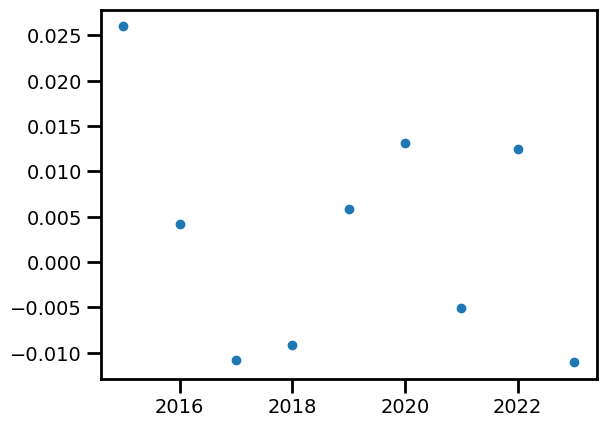

In [69]:
plt.scatter(np.arange(2015, 2024), cos_sims_global['mean'])
plt.show()

In [70]:
type(cos_sims_global['all'])

numpy.ndarray

In [71]:
data_for_seaborn={years[i]:list(_) for i, _ in enumerate(cos_sims_global['all'])}

<Axes: >

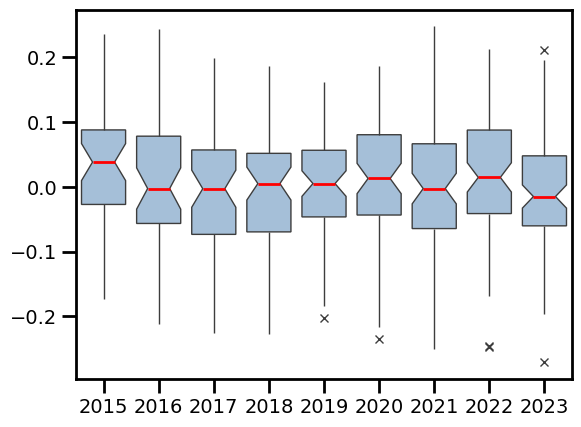

In [72]:
seaborn.boxplot(data=data_for_seaborn, notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2})

Mann-Kendall required?

## By sector

In [73]:
secs, k_secs=np.unique(vectors['sector'], return_counts=True)

In [74]:
np.vstack((secs, k_secs)).T

array([['01', '61'],
       ['02', '82'],
       ['03', '84'],
       ['04', '47'],
       ['05', '52'],
       ['06', '41'],
       ['07', '54'],
       ['08', '49'],
       ['09', '25'],
       ['10', '37'],
       ['11', '41']], dtype='<U21')

In [75]:
sec_helper

{'01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology',
 '10': 'Telecommunications',
 '11': 'Utilities'}

In [76]:
cos_sims_by_sec=np.zeros(len(years)*len(secs), dtype=[('year', 'i4'),('sector', 'U2'),('mean', 'f8'), ('all', object)])

In [77]:
for i_y, year in enumerate(tqdm(years)):
    for i_s, sec in enumerate(secs):
        cos_sims_by_sec[i_y*len(secs)+i_s]['year']=year
        cos_sims_by_sec[i_y*len(secs)+i_s]['sector']=sec
        cos_sims_by_sec[i_y*len(secs)+i_s]['all']=np.array([float(util.cos_sim(goalvecs[-1], vec)) for vec in vectors[np.logical_and(vectors['year']==year, vectors['sector']==sec)]['vector']])
        cos_sims_by_sec[i_y*len(secs)+i_s]['mean']=np.mean(cos_sims_by_sec[i_y*len(secs)+i_s]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


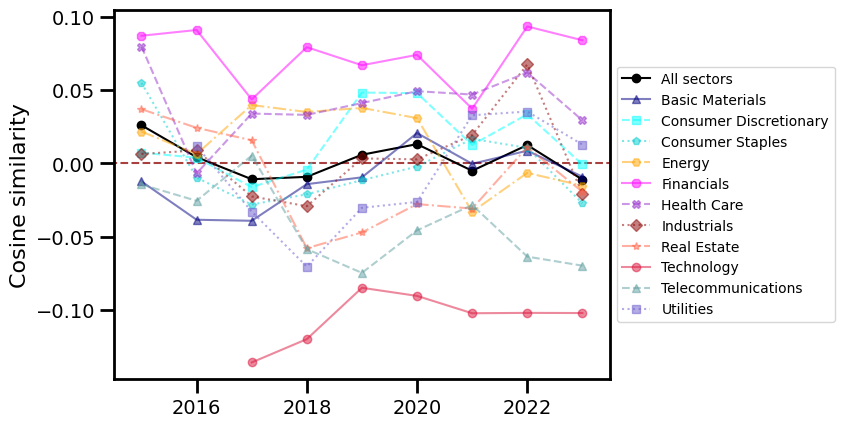

In [176]:
plt.hlines(0., 2010, 2030, ls='--', color='darkred', alpha=0.75)
plt.plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='All sectors', alpha=1., color='black')
for sec in secs:
    plt.plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], alpha=0.5, **sec_plots_feat[sec], label=sec_helper[sec])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(2014.5, 2023.5)
plt.ylabel('Cosine similarity', fontsize=16)
plt.savefig('./NewPlots/trends_sec_vs_all_sdgs.png', bbox_inches='tight', dpi=300)
plt.show()

Even if it's awful, continuous lines is even worse (just checked).

## By SDG

In [96]:
sdgs=[] 
for goalvecfile in goalvecfiles:
    sdg=goalvecfile.split('_')[0].split('-')[1]
    if sdg.isnumeric():
        sdgs.append(sdg)

In [97]:
cos_sims_by_sdg=np.zeros(len(years)*len(goalvecfiles), dtype=[('year', 'i4'),('SDG', 'U2'),('mean', 'f8'), ('all', object)])

In [98]:
vectors.dtype

dtype([('year', '<i4'), ('sector', '<U2'), ('company', '<U100'), ('vector', 'O')])

In [99]:
for i_y, year in enumerate(tqdm(years)):
    for i_s, sdg in enumerate(sdgs):
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['year']=year
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['SDG']=sdg
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['all']=np.array([float(util.cos_sim(goalvecs[i_s], vec)) for vec in vectors[vectors['year']==year]['vector']])
        cos_sims_by_sdg[i_y*len(sdgs)+i_s]['mean']=np.mean(cos_sims_by_sdg[i_y*len(sdgs)+i_s]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

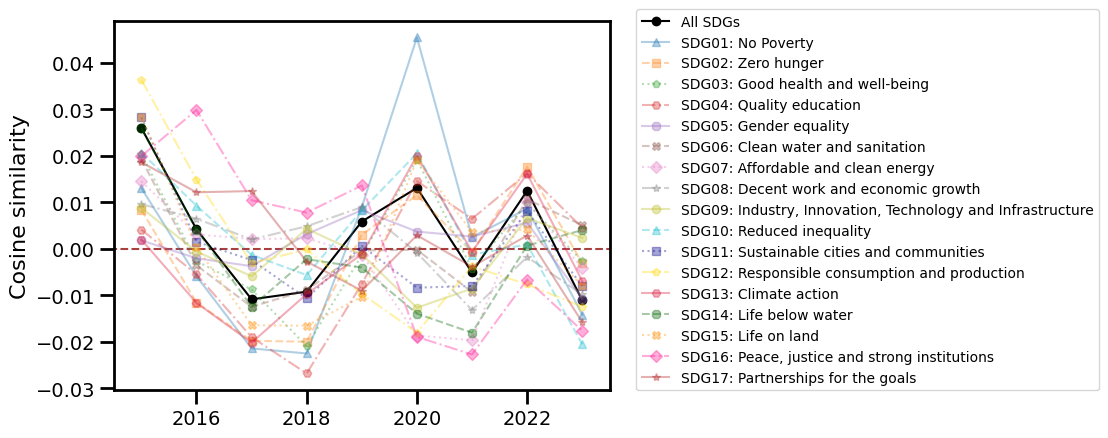

In [175]:
plt.hlines(0., 2010, 2030, ls='--', color='darkred', alpha=0.75)
plt.plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='All SDGs', color='black')
for i_sdg,sdg in enumerate(sdgs):
    plt.plot(cos_sims_by_sdg[cos_sims_by_sdg['SDG']==sdg]['year'], cos_sims_by_sdg[cos_sims_by_sdg['SDG']==sdg]['mean'], label='SDG'+sdg+': '+sdg_helper[sdg], alpha=0.35, color=sdg_color_list[i_sdg], ls=_lss[i_sdg % len(_lss)], marker=_markers[i_sdg %len(_markers)])
plt.legend(loc=1, bbox_to_anchor=(2.0, 1.05))
plt.xlim(2014.5, 2023.5)
plt.ylabel('Cosine similarity', fontsize=16)
plt.savefig('./NewPlots/trends_all_secs_vs_sdgs.png', bbox_inches='tight', dpi=300)
plt.show()

## By sector, by SDG

In [88]:
secs, k_secs=np.unique(vectors['sector'], return_counts=True)

In [89]:
cos_sims_by_sec_by_SDG=np.zeros(len(years)*len(secs)*len(goalvecfiles), dtype=[('year', 'i4'),('sector', 'U2'),('SDG', 'U2'),('mean', 'f8'), ('all', object)])

In [90]:
for i_y, year in enumerate(tqdm(years)):
    for i_s, sec in enumerate(secs):
        for i_sdg, sdg in enumerate(sdgs):
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['year']=year
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['sector']=sec
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['SDG']=sdg
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['all']=np.array([float(util.cos_sim(goalvecs[i_sdg], vec)) for vec in vectors[np.logical_and(vectors['year']==year, vectors['sector']==sec)]['vector']])
            cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['mean']=np.mean(cos_sims_by_sec_by_SDG[i_y*len(secs)*len(sdgs)+i_s*len(sdgs)+i_sdg]['all'])
            

  0%|          | 0/9 [00:00<?, ?it/s]

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


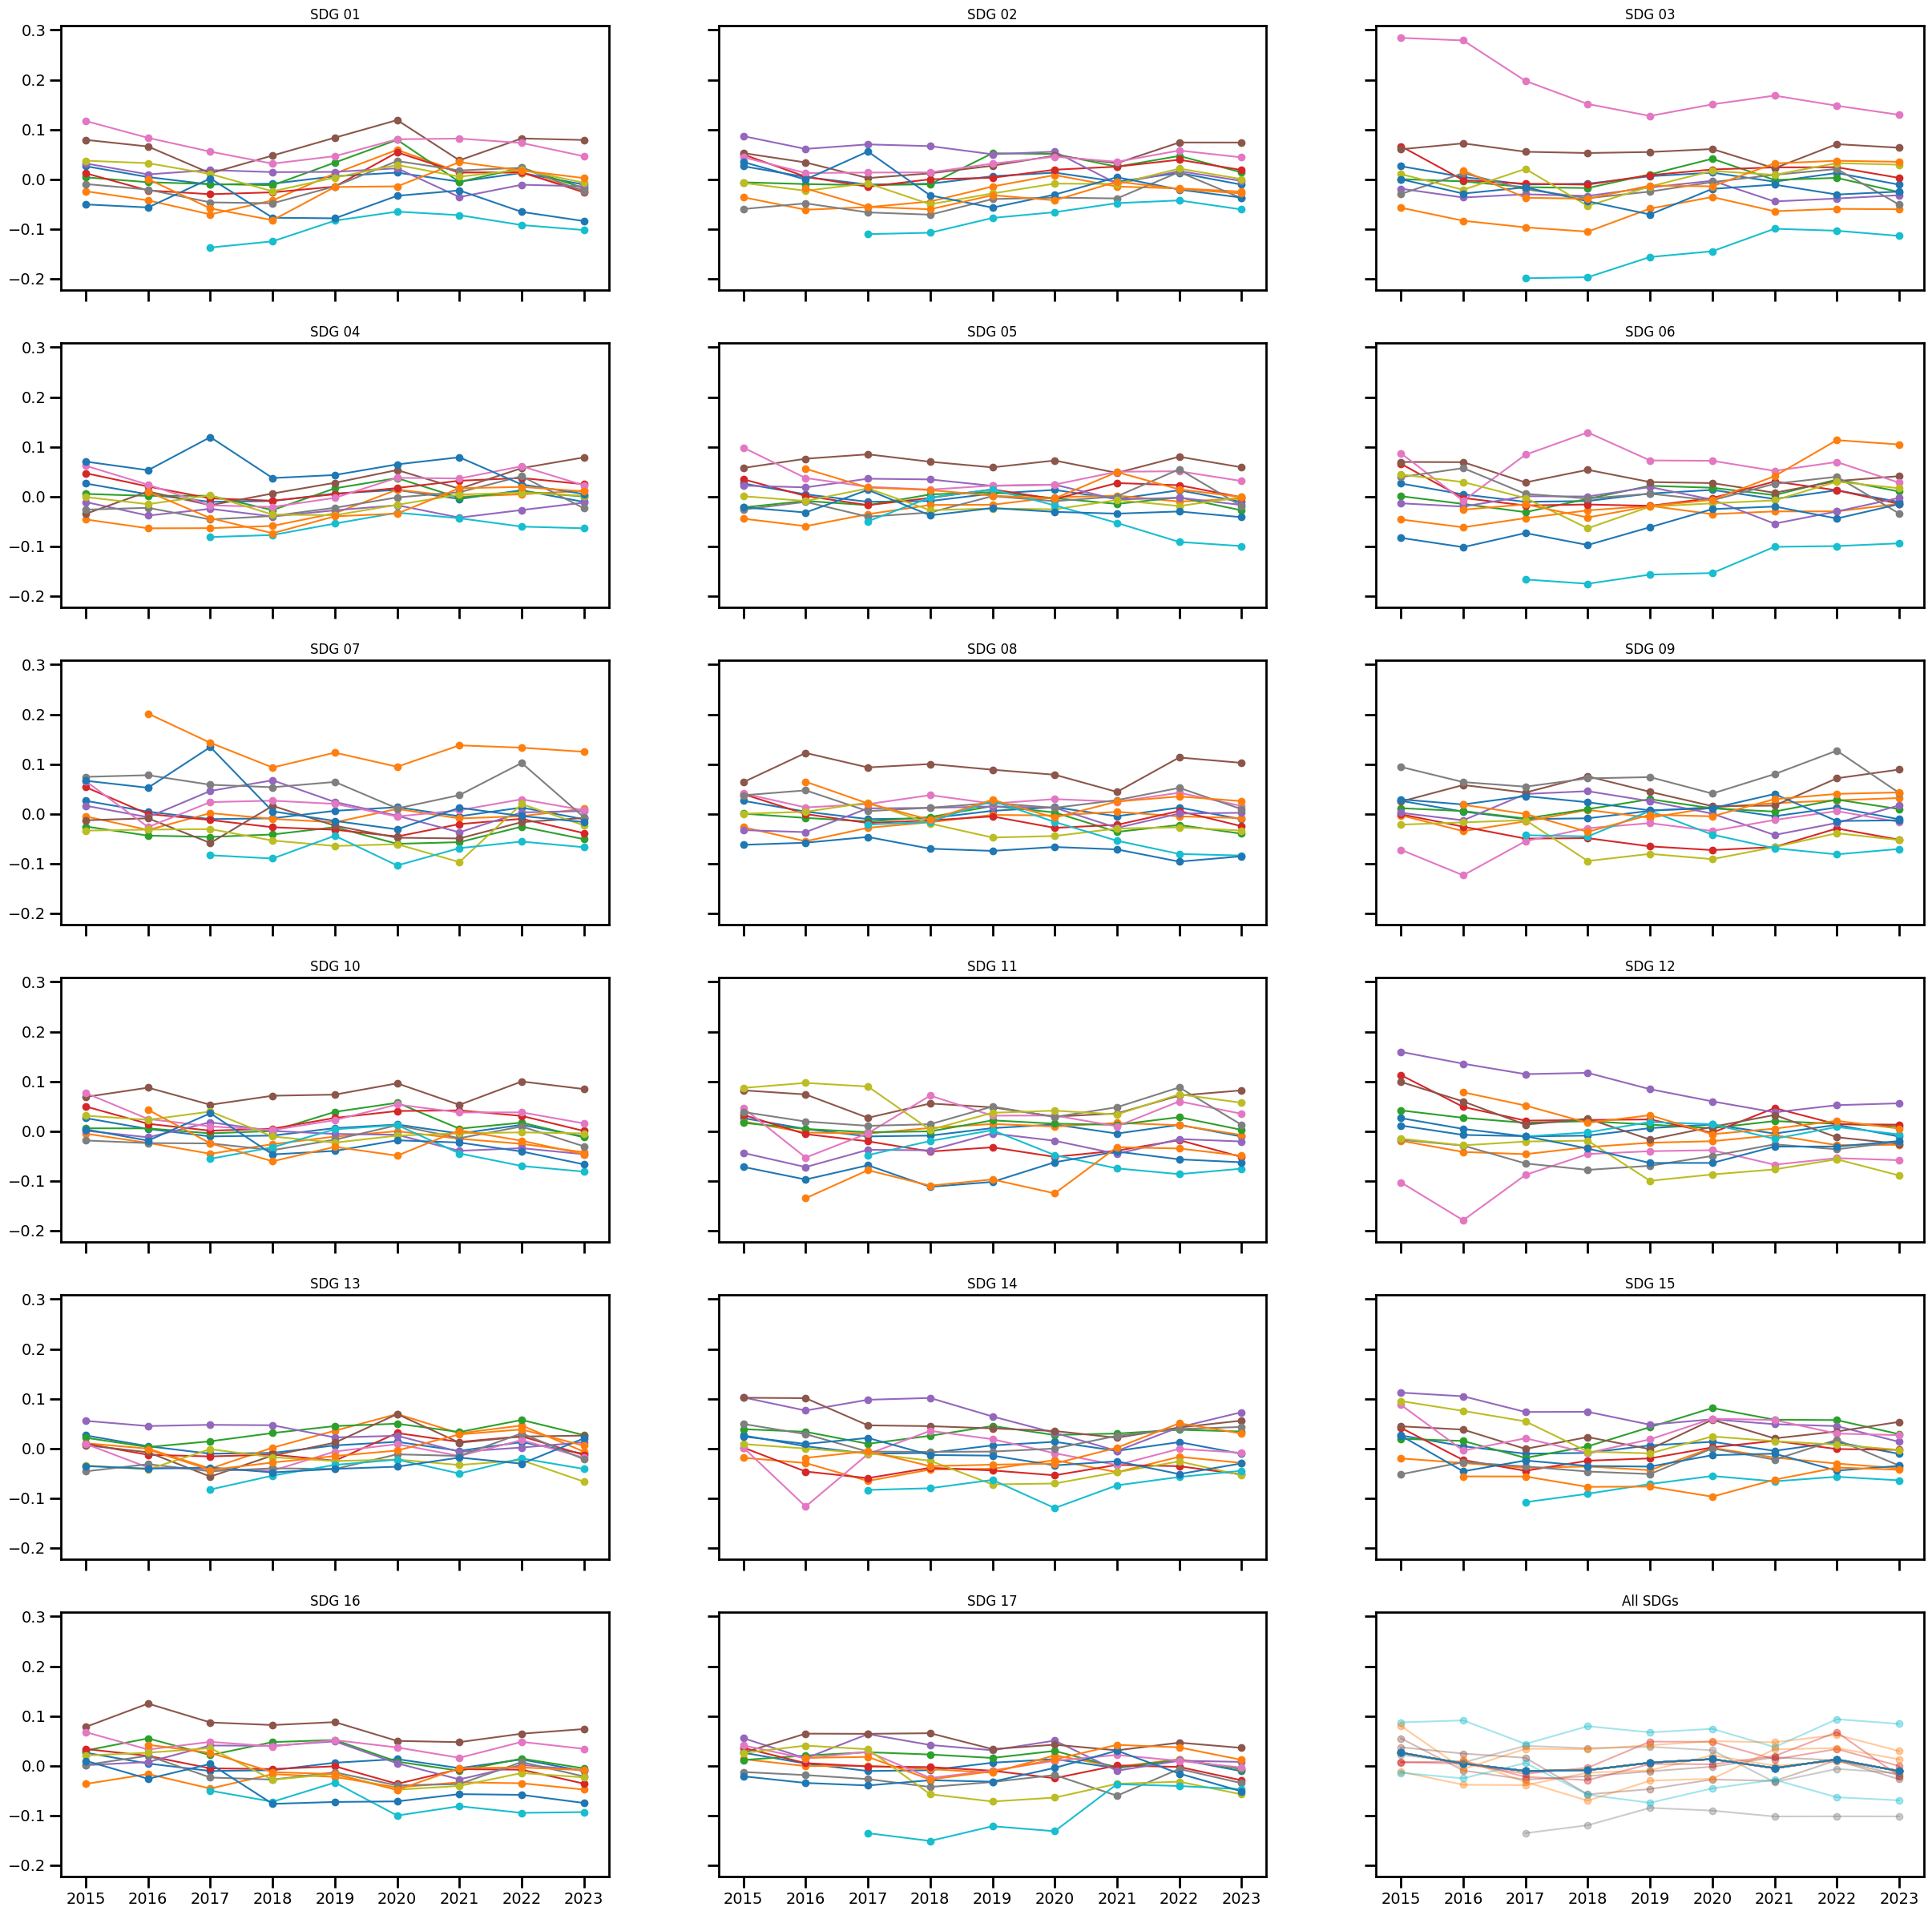

In [98]:
fig, axs=plt.subplots(6, 3, sharex=True, sharey=True, figsize=(30, 30))
for i_sdg, sdg in enumerate(sdgs):
    x_i=i_sdg//3
    y_i=i_sdg % 3
    axs[x_i, y_i].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    for sec in secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec)
    #axs[x_i, y_i].legend()
    axs[x_i, y_i].set_title('SDG '+sdg)
for sec in secs:
    axs[5,2].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    axs[5,2].plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec, alpha=0.4)
    axs[5,2].set_title('All SDGs')

plt.show()

To be improved.

## Mann Kendall

### Global

In [57]:
mk.original_test(cos_sims_global['mean'])

Mann_Kendall_Test(trend='no trend', h=False, p=0.6021675277481957, z=-0.5212860351426869, Tau=-0.16666666666666666, s=-6.0, var_s=92.0, slope=-0.00111755864103585, intercept=0.008690450333379876)

Mmm, ok...

### By sector

In [58]:
for sec in secs:
    cacca=mk.original_test(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'])
    print(f'sec={sec:}, \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')

sec=01, no trend  , p-value=7.63e-02, slope=4.64e-03
sec=02, no trend  , p-value=7.54e-01, slope=1.31e-03
sec=03, no trend  , p-value=1.00e+00, slope=-2.21e-04
sec=04, no trend  , p-value=1.75e-01, slope=-4.68e-03
sec=05, no trend  , p-value=9.17e-01, slope=-6.93e-04
sec=06, no trend  , p-value=7.54e-01, slope=3.42e-03
sec=07, no trend  , p-value=7.54e-01, slope=1.88e-03
sec=08, no trend  , p-value=3.48e-01, slope=-6.05e-03
sec=09, no trend  , p-value=5.48e-01, slope=3.56e-03
sec=10, no trend  , p-value=7.63e-02, slope=-6.63e-03
sec=11, no trend  , p-value=1.08e-01, slope=5.91e-03


Mmm, ok...

### By SDG

In [104]:
_p_vals=[]
for sdg in sdgs:
    cacca=mk.original_test(cos_sims_by_sdg[cos_sims_by_sdg['SDG']==sdg]['mean'])
    print(f'sdg={sdg:}, \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')
    _p_vals.append(cacca.p)

sdg=01, no trend  , p-value=9.17e-01, slope=-3.71e-04
sdg=02, no trend  , p-value=6.02e-01, slope=1.75e-03
sdg=03, no trend  , p-value=9.17e-01, slope=-1.24e-04
sdg=04, no trend  , p-value=2.51e-01, slope=2.24e-03
sdg=05, no trend  , p-value=7.54e-01, slope=3.28e-04
sdg=06, no trend  , p-value=6.02e-01, slope=9.45e-04
sdg=07, no trend  , p-value=7.63e-02, slope=-1.56e-03
sdg=08, decreasing, p-value=1.65e-02, slope=-2.21e-03
sdg=09, no trend  , p-value=6.02e-01, slope=-5.27e-04
sdg=10, no trend  , p-value=1.75e-01, slope=-3.04e-03
sdg=11, no trend  , p-value=3.48e-01, slope=-1.65e-03
sdg=12, decreasing, p-value=1.65e-02, slope=-4.12e-03
sdg=13, no trend  , p-value=3.48e-01, slope=2.11e-03
sdg=14, no trend  , p-value=3.48e-01, slope=-2.26e-03
sdg=15, no trend  , p-value=1.00e+00, slope=2.23e-04
sdg=16, decreasing, p-value=2.86e-02, slope=-5.24e-03
sdg=17, decreasing, p-value=2.86e-02, slope=-3.18e-03


In [102]:
sdg_helper['08'], sdg_helper['12'], sdg_helper['16'], sdg_helper['17']

('Decent work and economic growth',
 'Responsible consumption and production',
 'Peace, justice and strong institutions',
 'Partnerships for the goals')

In [105]:
fdr_th(_p_vals, 0.05)

0.0

### By sector, by SDG

In [61]:
for sdg in sdgs:
    print(f'\nSDG{sdg:}\n---------------')
    for sec in secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        cacca=mk.original_test(_selection['mean'])
        print(f'sec={sec:}, \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')


SDG01
---------------
sec=01, no trend  , p-value=1.75e-01, slope=5.84e-03
sec=02, no trend  , p-value=9.17e-01, slope=-1.28e-03
sec=03, no trend  , p-value=6.02e-01, slope=7.21e-04
sec=04, no trend  , p-value=1.18e-01, slope=-5.59e-03
sec=05, no trend  , p-value=7.54e-01, slope=1.48e-03
sec=06, no trend  , p-value=2.51e-01, slope=-4.14e-03
sec=07, no trend  , p-value=6.02e-01, slope=4.61e-03
sec=08, no trend  , p-value=1.75e-01, slope=-3.25e-03
sec=09, no trend  , p-value=5.48e-01, slope=5.87e-03
sec=10, no trend  , p-value=3.48e-01, slope=-3.03e-03
sec=11, no trend  , p-value=1.74e-01, slope=8.49e-03

SDG02
---------------
sec=01, no trend  , p-value=2.51e-01, slope=5.24e-03
sec=02, no trend  , p-value=4.66e-01, slope=4.53e-03
sec=03, no trend  , p-value=4.66e-01, slope=3.81e-03
sec=04, decreasing, p-value=9.15e-03, slope=-1.04e-02
sec=05, no trend  , p-value=2.51e-01, slope=6.75e-03
sec=06, no trend  , p-value=7.63e-02, slope=4.51e-03
sec=07, increasing, p-value=4.76e-02, slope=4.0

sec=10, no trend  , p-value=7.54e-01, slope=1.81e-03
sec=11, no trend  , p-value=7.11e-01, slope=3.68e-03


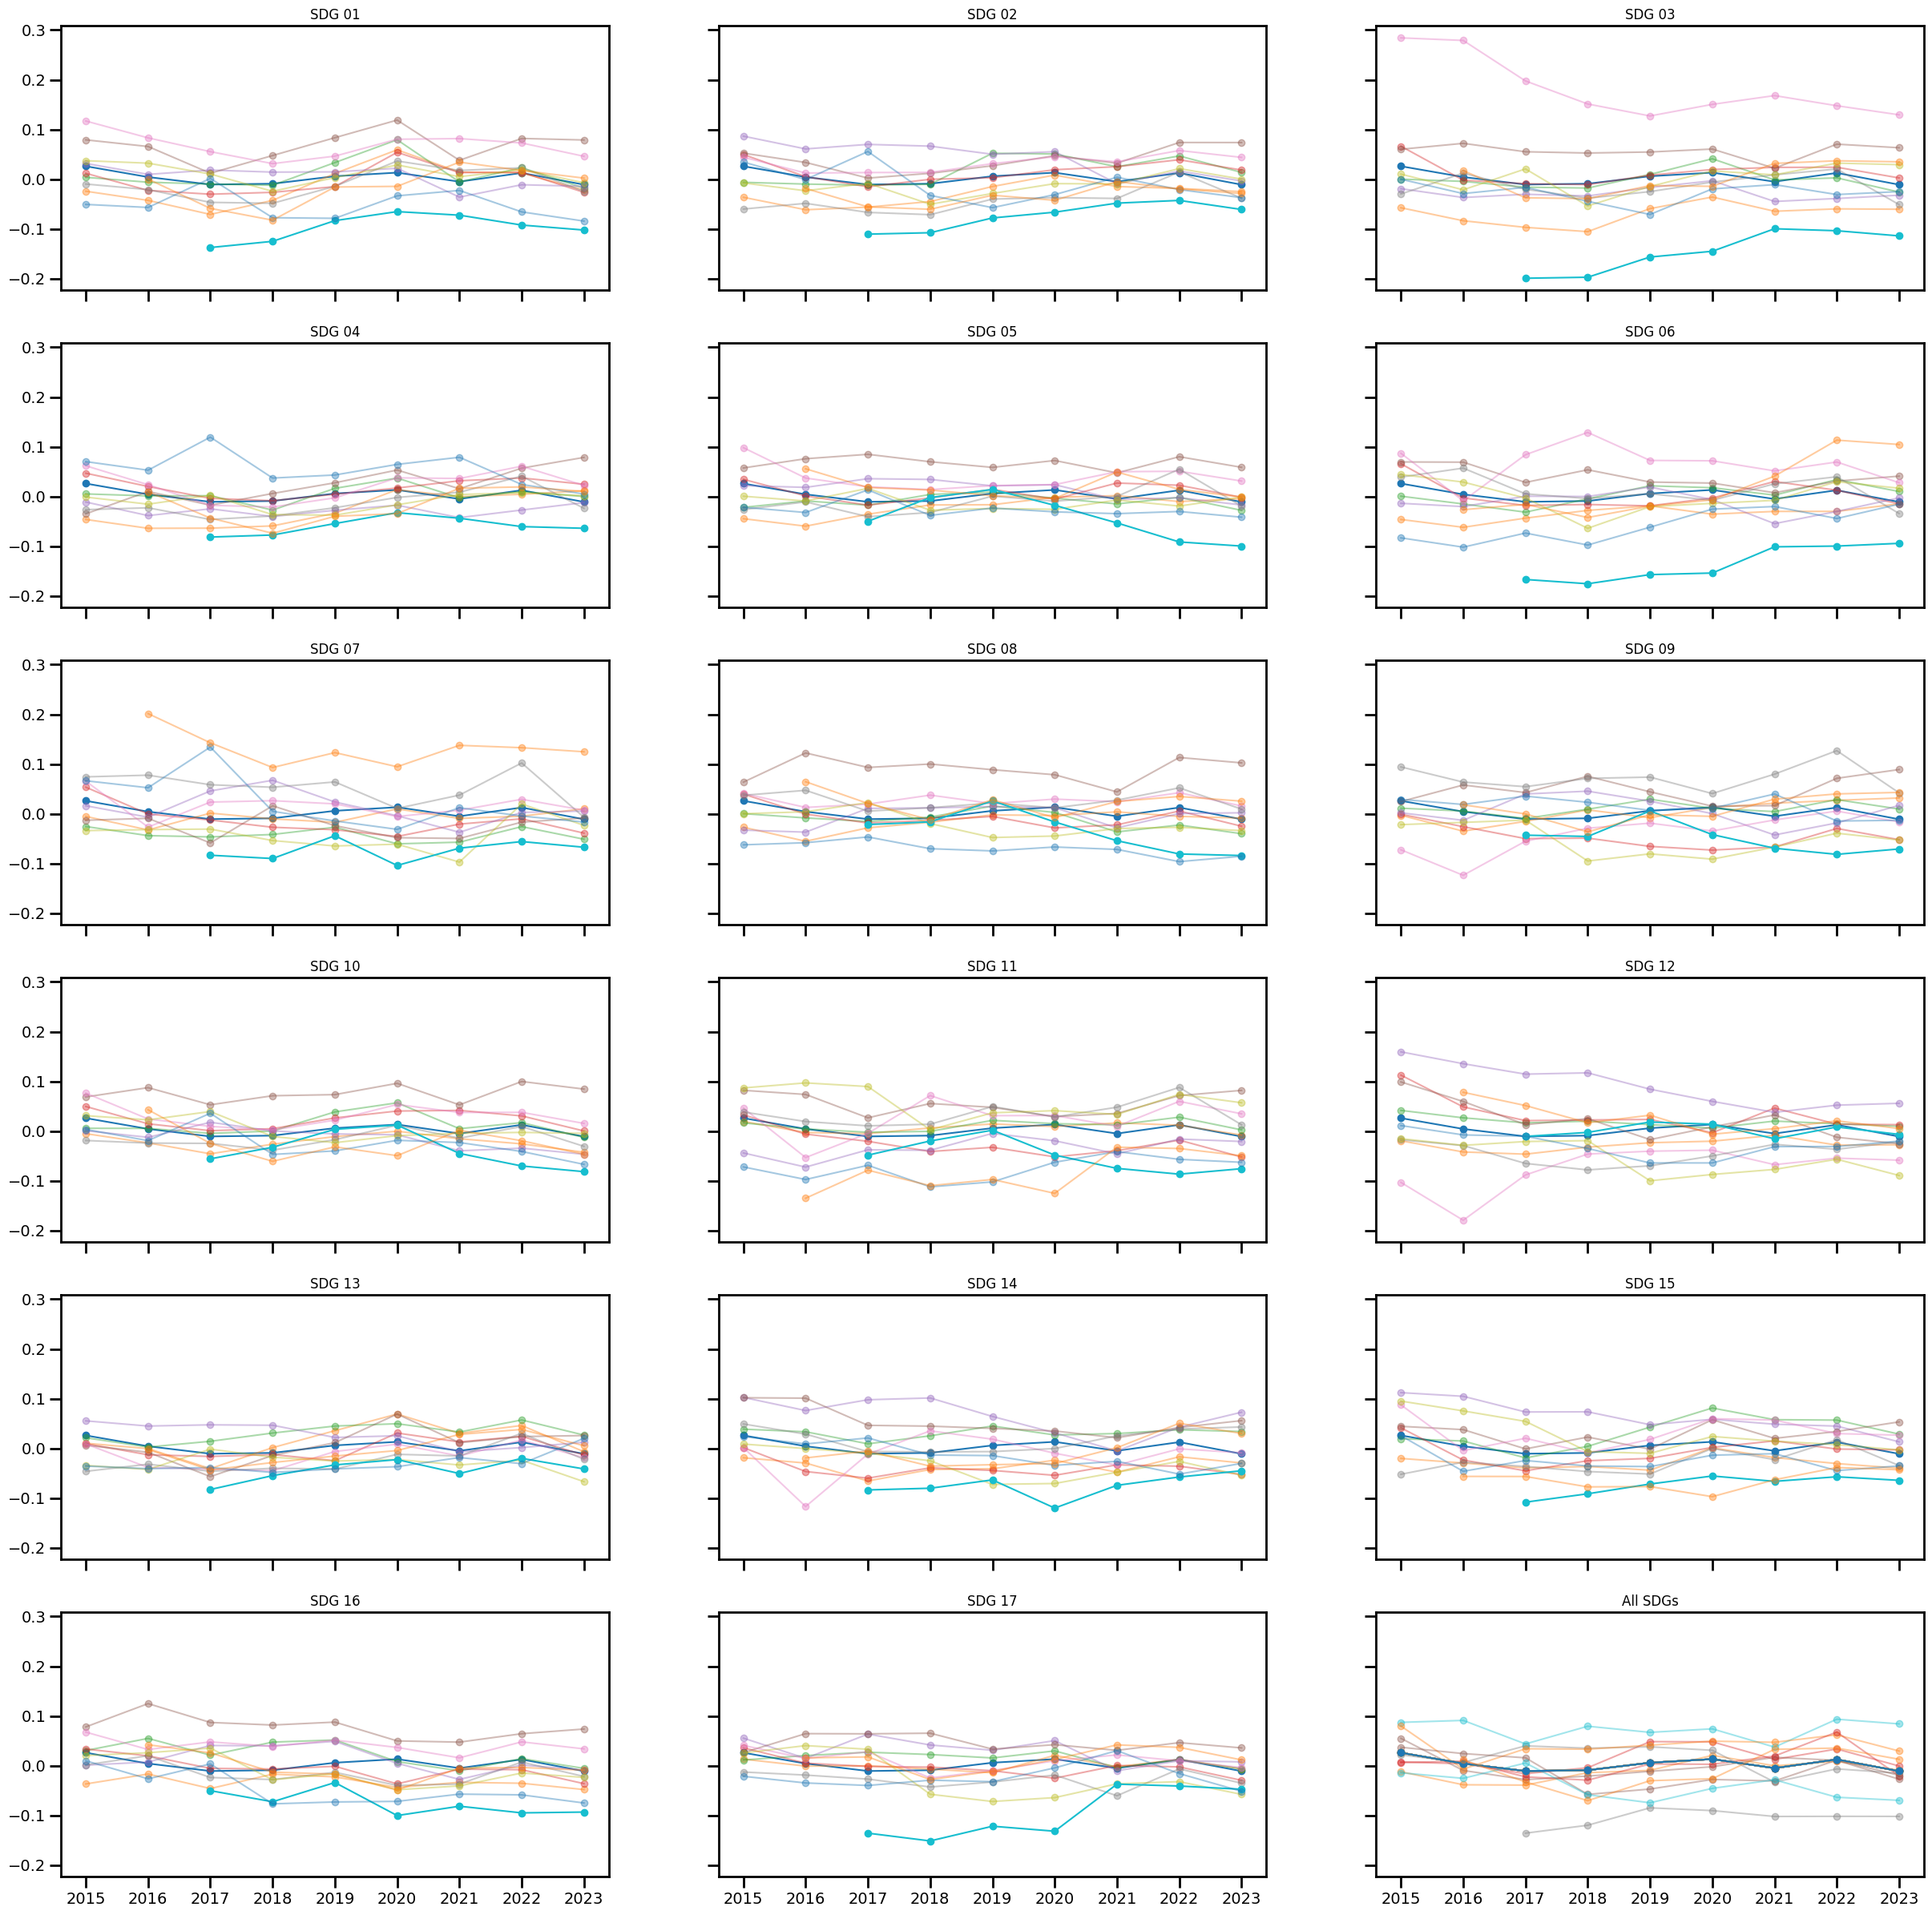

In [62]:
fig, axs=plt.subplots(6, 3, sharex=True, sharey=True, figsize=(30, 30))
for i_sdg, sdg in enumerate(sdgs):
    x_i=i_sdg//3
    y_i=i_sdg % 3
    axs[x_i, y_i].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    for sec in secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        if sec=='09':
            axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec)
        else:
            axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec, alpha=0.4)
    #axs[x_i, y_i].legend()
    axs[x_i, y_i].set_title('SDG '+sdg)
for sec in secs:
    axs[5,2].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global')
    axs[5,2].plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec, alpha=0.4)
    axs[5,2].set_title('All SDGs')

plt.show()

#### Mean old FDR

In [118]:
_p_vals={}
for sdg in sdgs:
    _p_vals[sdg]=[]
    for sec in secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        cacca=mk.original_test(_selection['mean'])
        _p_vals[sdg].append(cacca.p)

In [132]:
for sdg in sdgs:
    print(sdg, sdg_helper[sdg], fdr_th(_p_vals[sdg], 0.05))

01 No Poverty 0.0
02 Zero hunger 0.0
03 Good health and well-being 0.0
04 Quality education 0.0
05 Gender equality 0.0
06 Clean water and sanitation 0.0
07 Affordable and clean energy 0.0
08 Decent work and economic growth 0.0
09 Industry, Innovation, Technology and Infrastructure 0.0
10 Reduced inequality 0.0
11 Sustainable cities and communities 0.0
12 Responsible consumption and production 0.0
13 Climate action 0.0
14 Life below water 0.0
15 Life on land 0.004545454545454546
16 Peace, justice and strong institutions 0.0
17 Partnerships for the goals 0.0


In [130]:
np.where(_p_vals[sdg]<=fdr_th(_p_vals[sdg], 0.05))[0]+1

array([4])

In [131]:
sec_helper['04']

'Energy'

# Internal similarity

## Global trend

In [181]:
int_sim={}
for year in tqdm(years):
    _selection=vectors[vectors['year']==year]
    l_sel=len(_selection)
    counter=0
    l_entries=int(l_sel*(l_sel-1)/2)
    int_sim[year]=np.zeros(l_entries)
    for i in range(l_sel):
        for j in range(i+1, l_sel):
            int_sim[year][counter]=float(util.cos_sim(_selection[i]['vector'], _selection[j]['vector']))
            counter+=1
            

  0%|          | 0/9 [00:00<?, ?it/s]

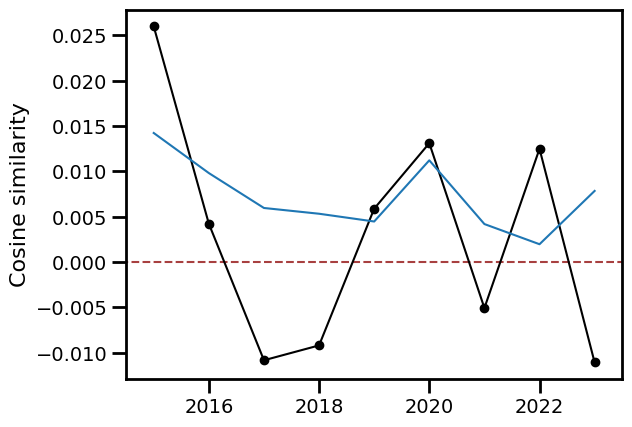

In [190]:
plt.hlines(0., 2010, 2030, ls='--', color='darkred', alpha=0.75)
plt.plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='All SDGs', color='black')
plt.plot(np.arange(2015, 2024), [np.mean(int_sim[year]) for year in years])
plt.xlim(2014.5, 2023.5)
plt.ylabel('Cosine similarity', fontsize=16)
plt.show()

In [193]:
from scipy.stats import spearmanr

In [194]:
spearmanr([np.mean(int_sim[year]) for year in years], cos_sims_global['mean'])

SignificanceResult(statistic=0.26666666666666666, pvalue=0.4879222748387009)

In [185]:
max([np.mean(int_sim[year]) for year in years])

0.014232408059782117

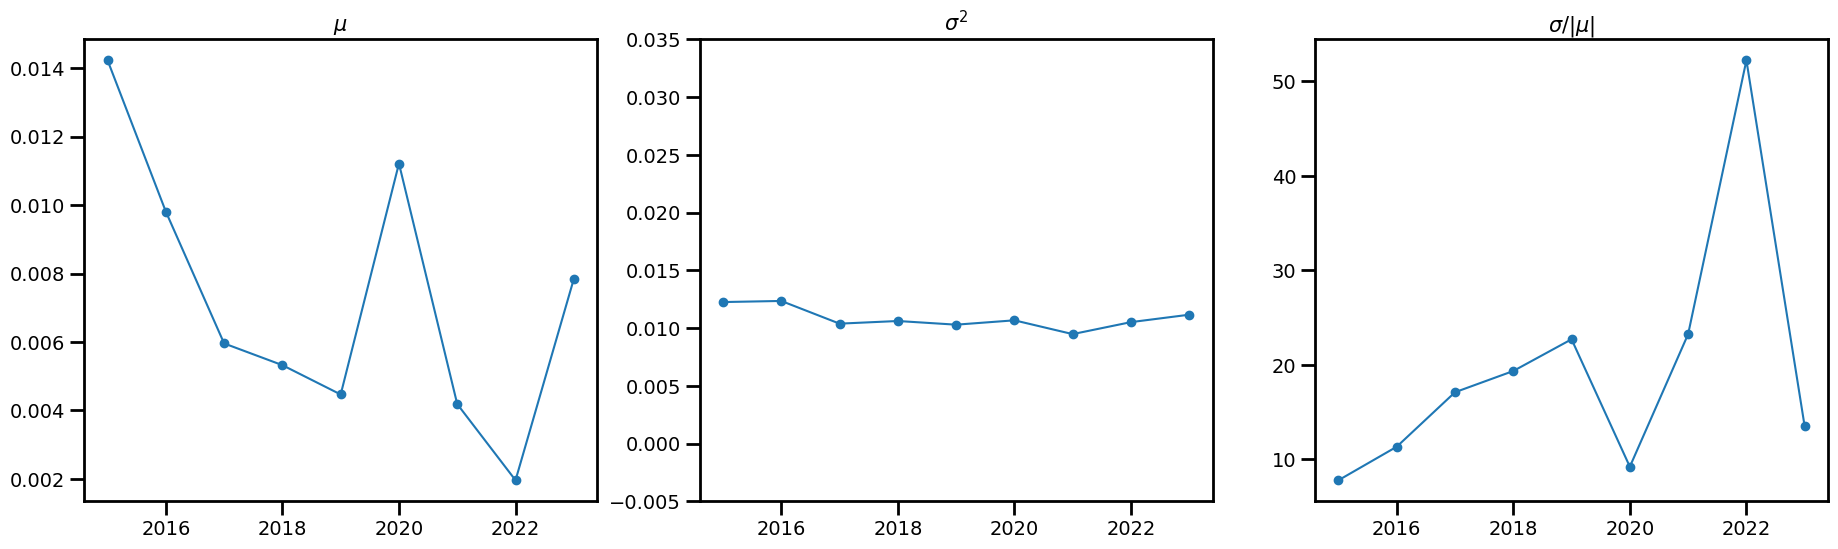

In [65]:
fig, axs=plt.subplots(1, 3, sharex=True, figsize=(22.5, 6))
axs[0].plot(np.arange(2015, 2024), [np.mean(int_sim[year]) for year in years], marker='o')
axs[0].set_title(r'$\mu$', fontsize=15)
#axs[0].set_ylim(-0.005, 0.035)
axs[1].plot(np.arange(2015, 2024), [np.var(int_sim[year]) for year in years], marker='o')
axs[1].set_title(r'$\sigma^2$', fontsize=15)
axs[1].set_ylim(-0.005, 0.035)
axs[2].plot(np.arange(2015, 2024), [np.std(int_sim[year])/np.abs(np.mean(int_sim[year])) for year in years], marker='o')
axs[2].set_title(r'$\sigma/|\mu|$', fontsize=15)

plt.show()

## Global MK

### Mean

In [66]:
mk.original_test([np.mean(int_sim[year]) for year in years])

Mann_Kendall_Test(trend='no trend', h=False, p=0.07633274037635718, z=-1.7723725194851356, Tau=-0.5, s=-18.0, var_s=92.0, slope=-0.000817352694852426, intercept=0.009228845401855451)

In [67]:
years[:5]

array([2015, 2016, 2017, 2018, 2019], dtype=int32)

In [68]:
mk.original_test([np.mean(int_sim[year]) for year in years[:5]])

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0274863361115103, z=-2.2045407685048604, Tau=-1.0, s=-10.0, var_s=16.666666666666668, slope=-0.0023419841435568084, intercept=0.010643402909559365)

In [69]:
years[5:]

array([2020, 2021, 2022, 2023], dtype=int32)

In [70]:
mk.original_test([np.mean(int_sim[year]) for year in years[5:]])

Mann_Kendall_Test(trend='no trend', h=False, p=0.7340951823194757, z=-0.3396831102433787, Tau=-0.3333333333333333, s=-2.0, var_s=8.666666666666666, slope=-0.001674753619802417, intercept=0.008526481861585253)

### Variance

In [71]:
mk.original_test([np.var(int_sim[year]) for year in years])

Mann_Kendall_Test(trend='no trend', h=False, p=0.46551216987418664, z=-0.7298004491997617, Tau=-0.2222222222222222, s=-8.0, var_s=92.0, slope=-0.00015340500053081404, intercept=0.01121890225722044)

In [72]:
years[:5]

array([2015, 2016, 2017, 2018, 2019], dtype=int32)

In [73]:
mk.original_test([np.var(int_sim[year]) for year in years[:5]])

Mann_Kendall_Test(trend='no trend', h=False, p=0.22067136191984682, z=-1.224744871391589, Tau=-0.6, s=-6.0, var_s=16.666666666666668, slope=-0.000518324501270221, intercept=0.011641931257637626)

In [74]:
years[4:]

array([2019, 2020, 2021, 2022, 2023], dtype=int32)

In [75]:
mk.original_test([np.var(int_sim[year]) for year in years[4:]])

Mann_Kendall_Test(trend='no trend', h=False, p=0.4624327264504764, z=0.7348469228349533, Tau=0.4, s=4.0, var_s=16.666666666666668, slope=0.00018915157130122202, intercept=0.010130421151903952)

## Trend by sector

In [76]:
int_sim_by_sec={}
for sec in secs:
    int_sim_by_sec[sec]={}
    for year in tqdm(years):
        _selection=vectors[np.logical_and(vectors['year']==year,vectors['sector']==sec)]
        l_sel=len(_selection)
        counter=0
        l_entries=int(l_sel*(l_sel-1)/2)
        int_sim_by_sec[sec][year]=np.zeros(l_entries)
        for i in range(l_sel):
            for j in range(i+1, l_sel):
                int_sim_by_sec[sec][year][counter]=float(util.cos_sim(_selection[i]['vector'], _selection[j]['vector']))
                counter+=1
            

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [77]:
def couples2n(a):
    '''
    Given the number of couples, it returns the number of single elements
    '''
    return int((1+np.sqrt(1+8*a))/2)

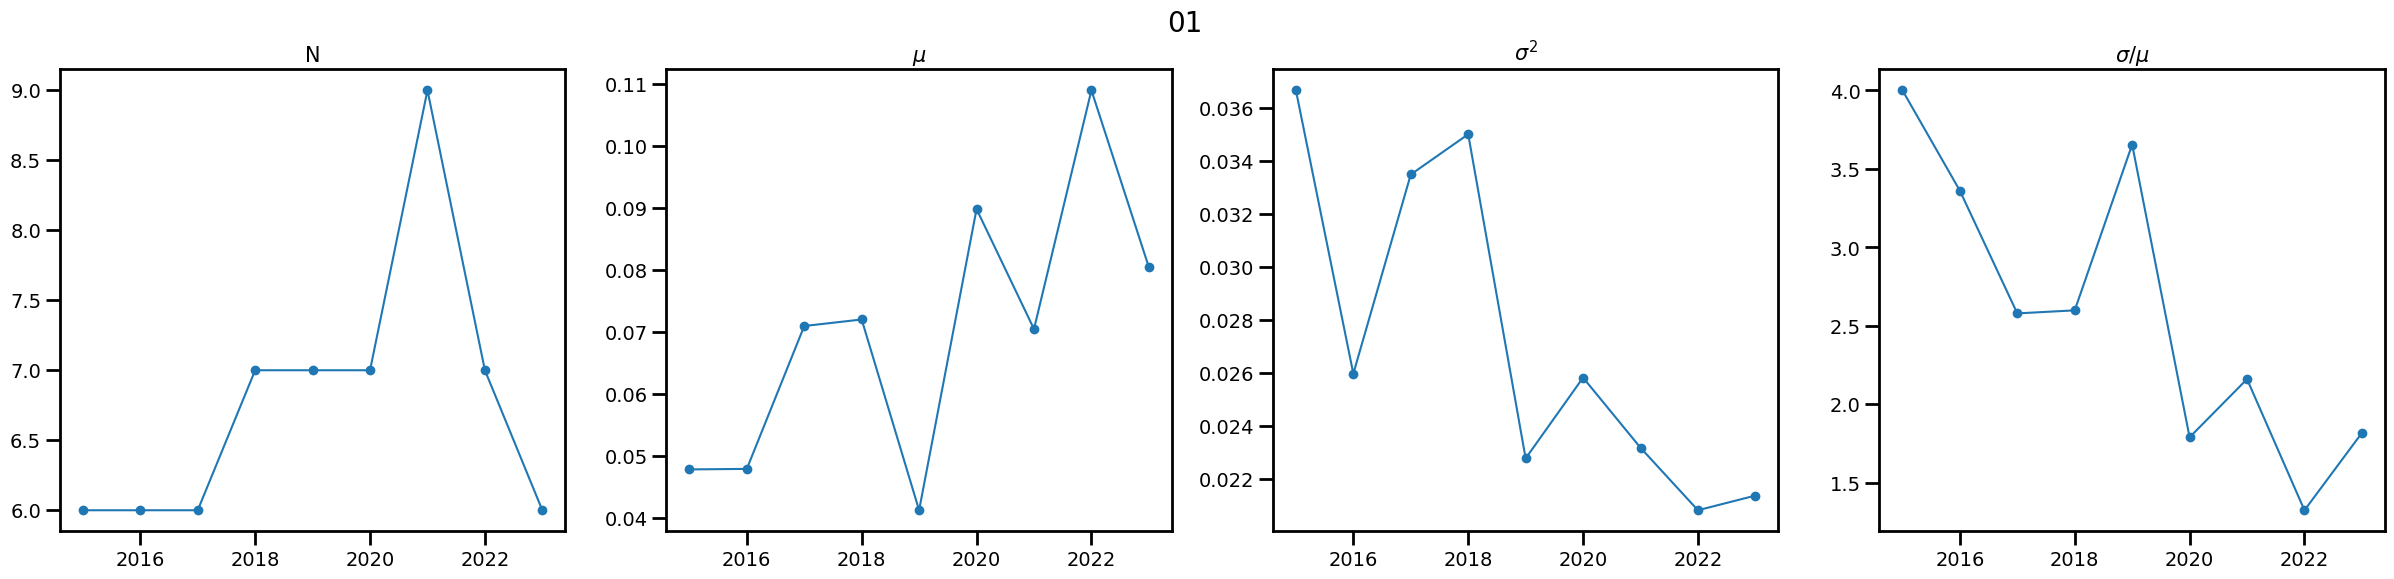

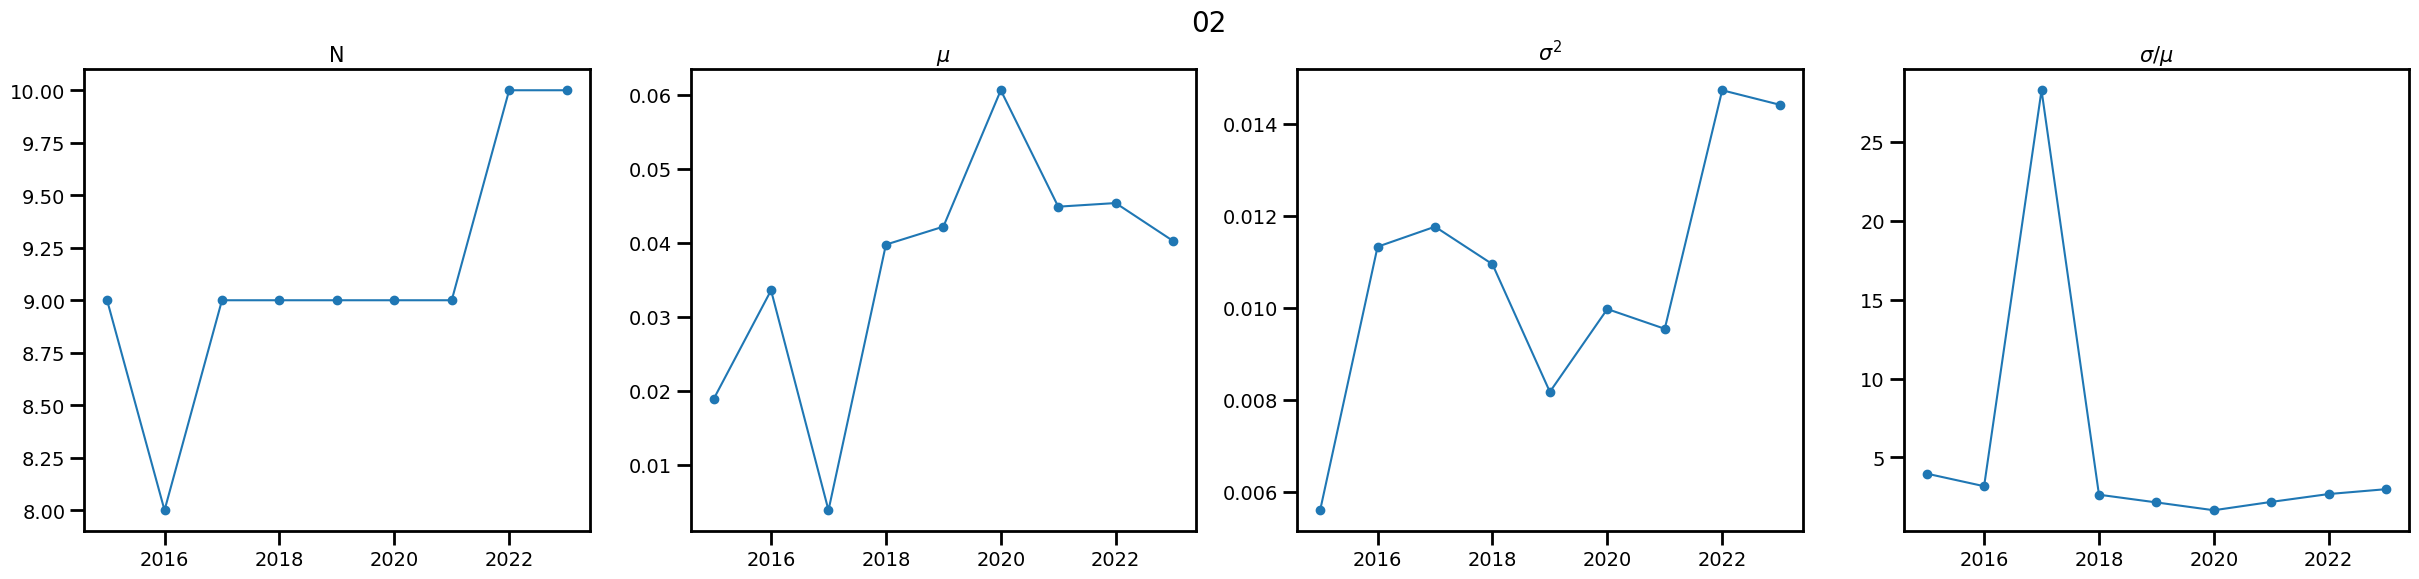

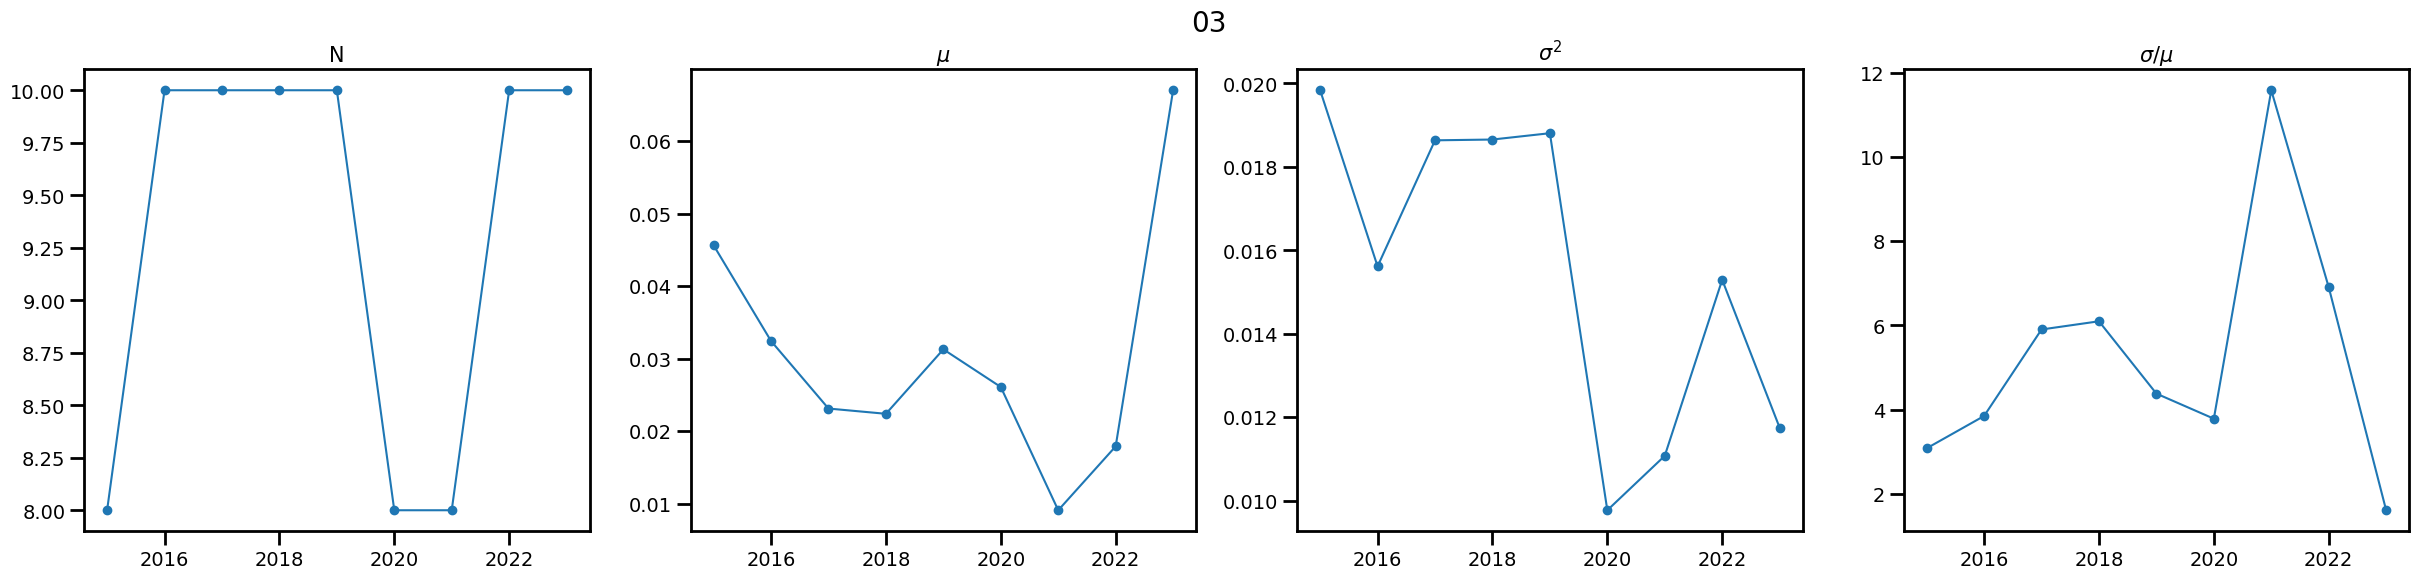

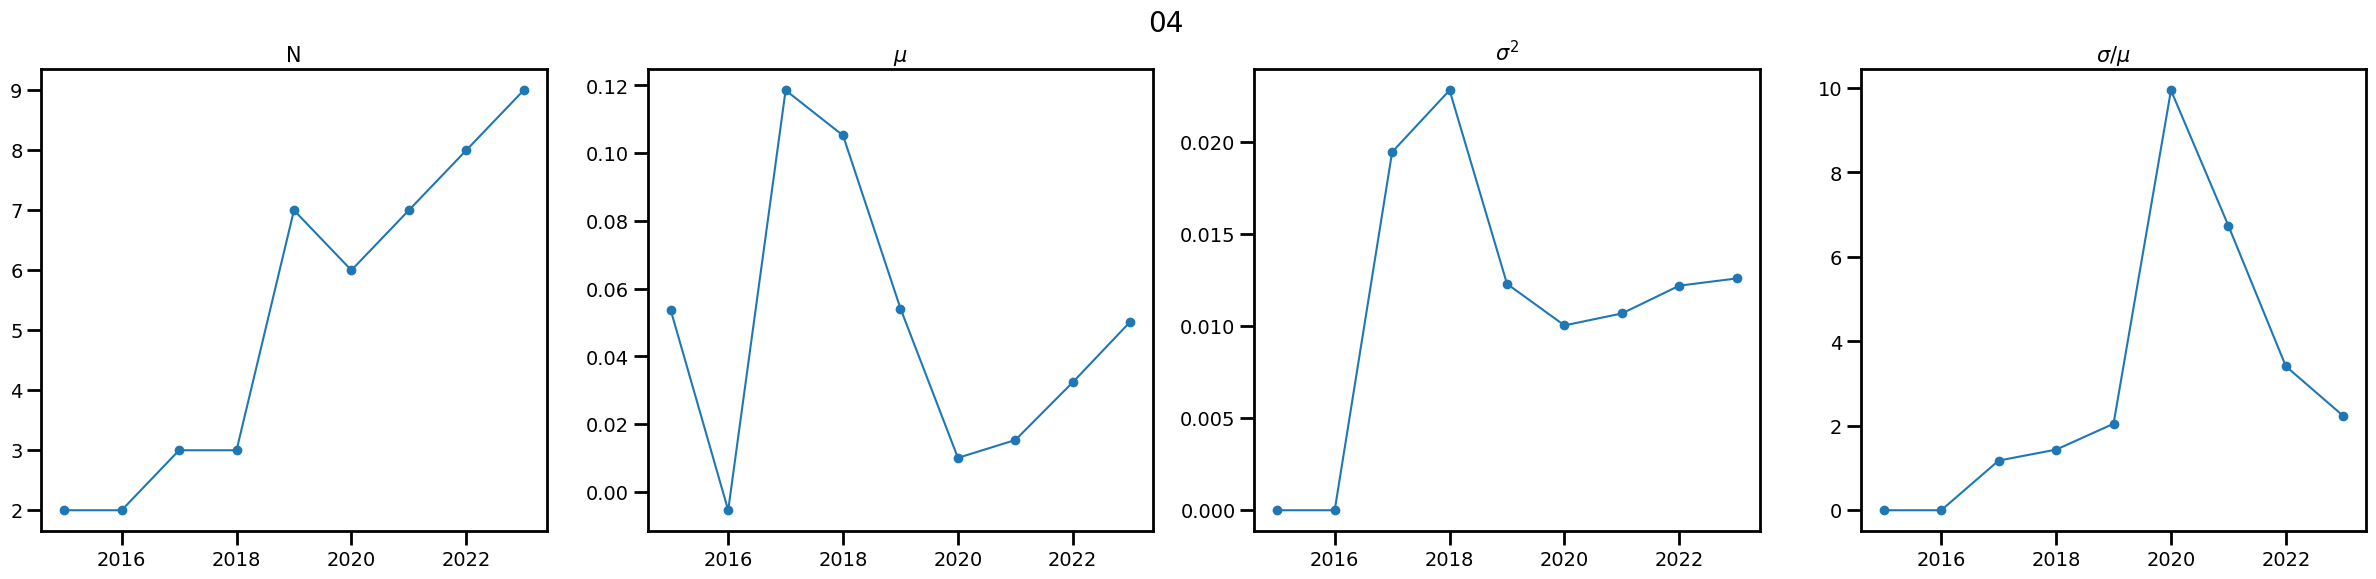

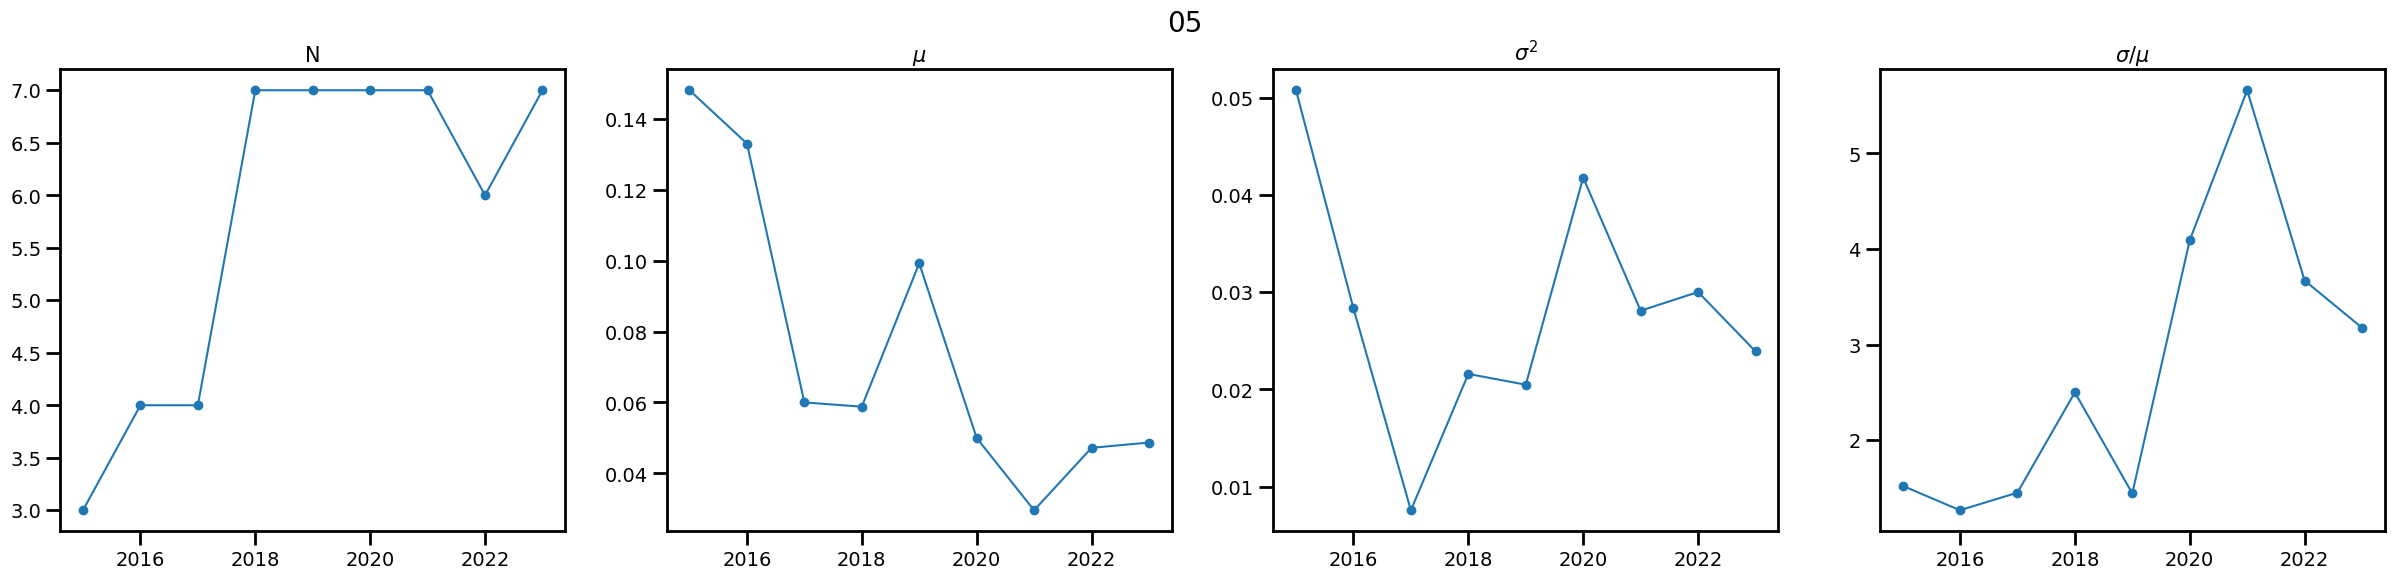

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


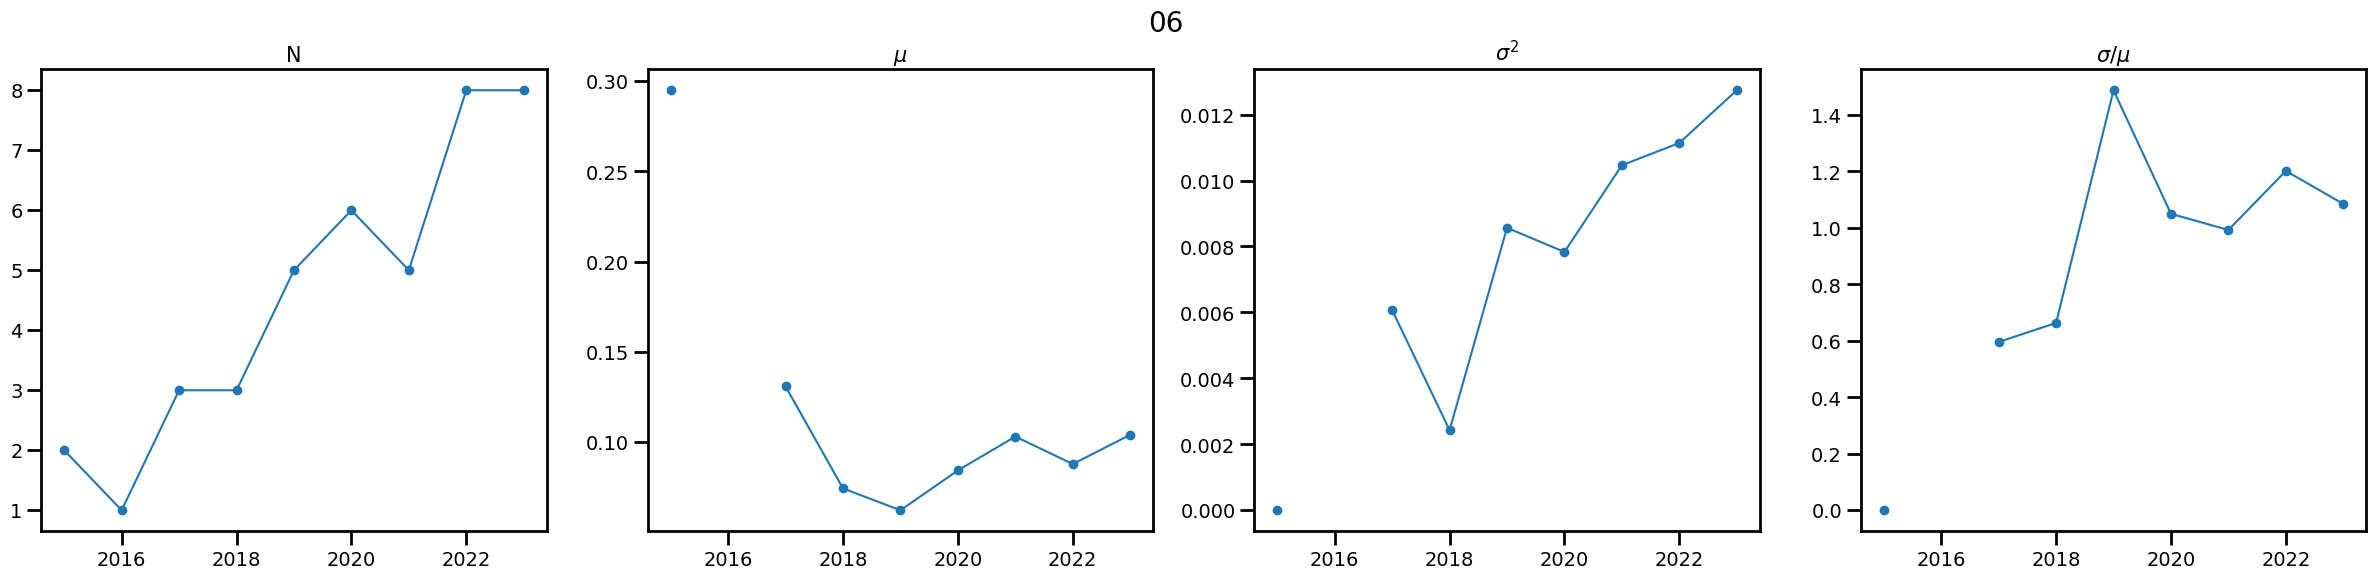

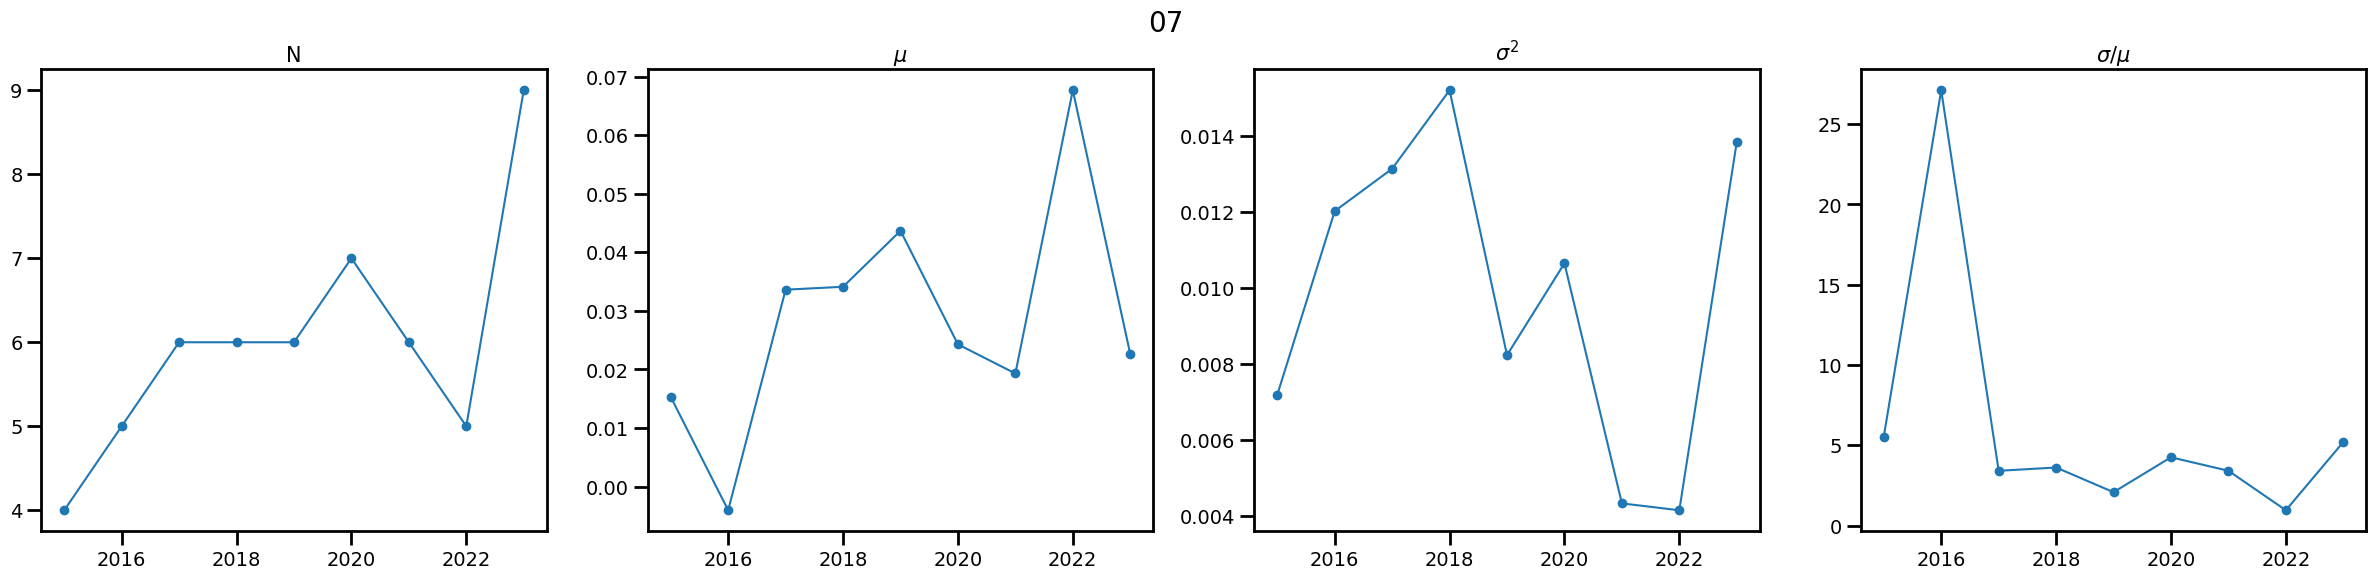

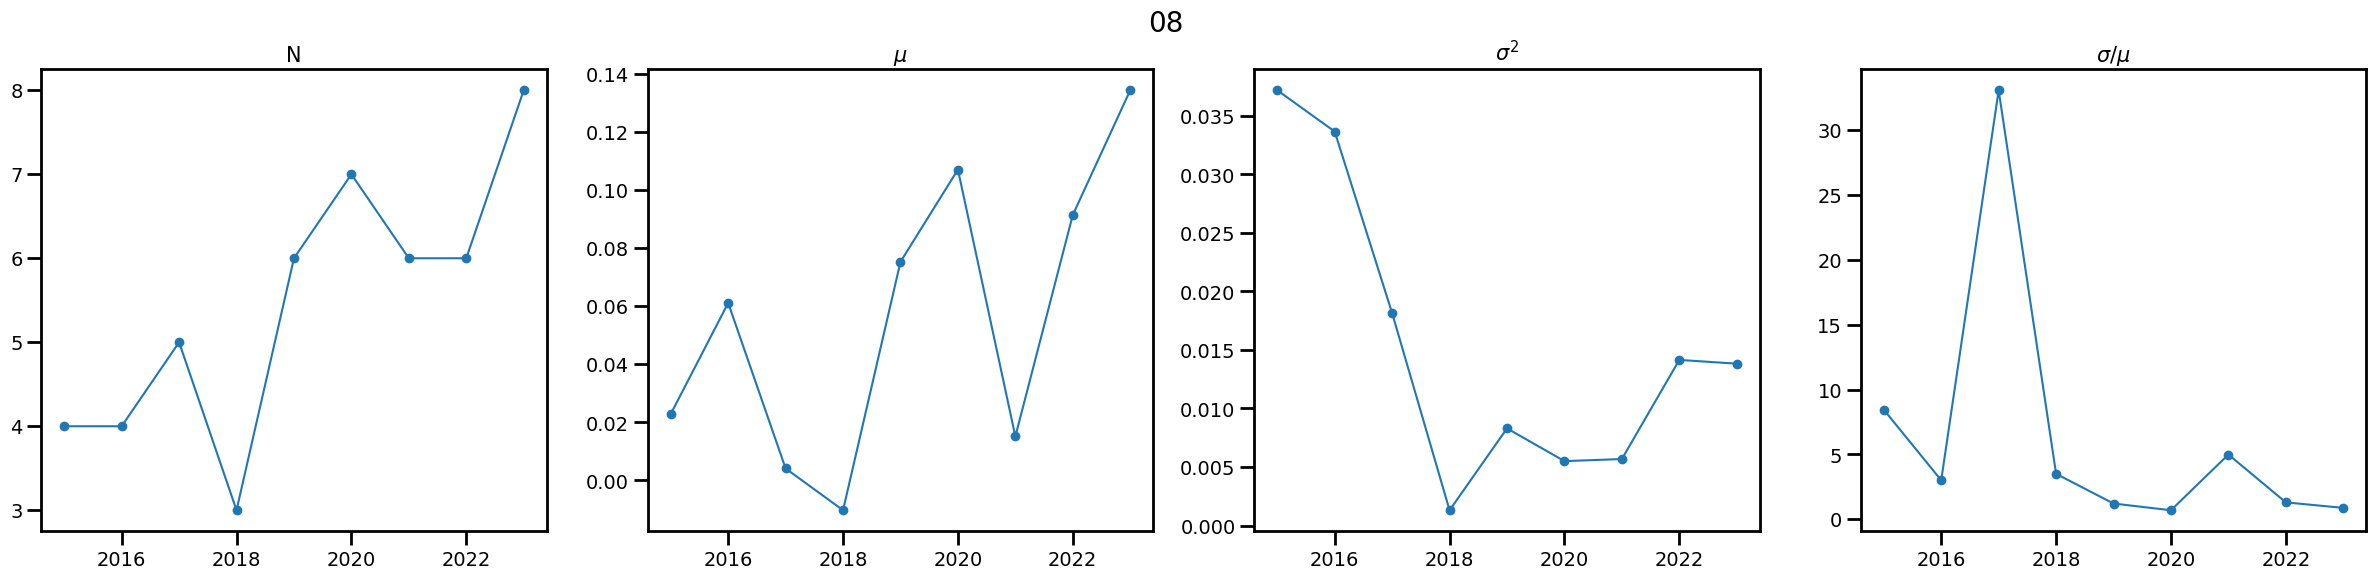

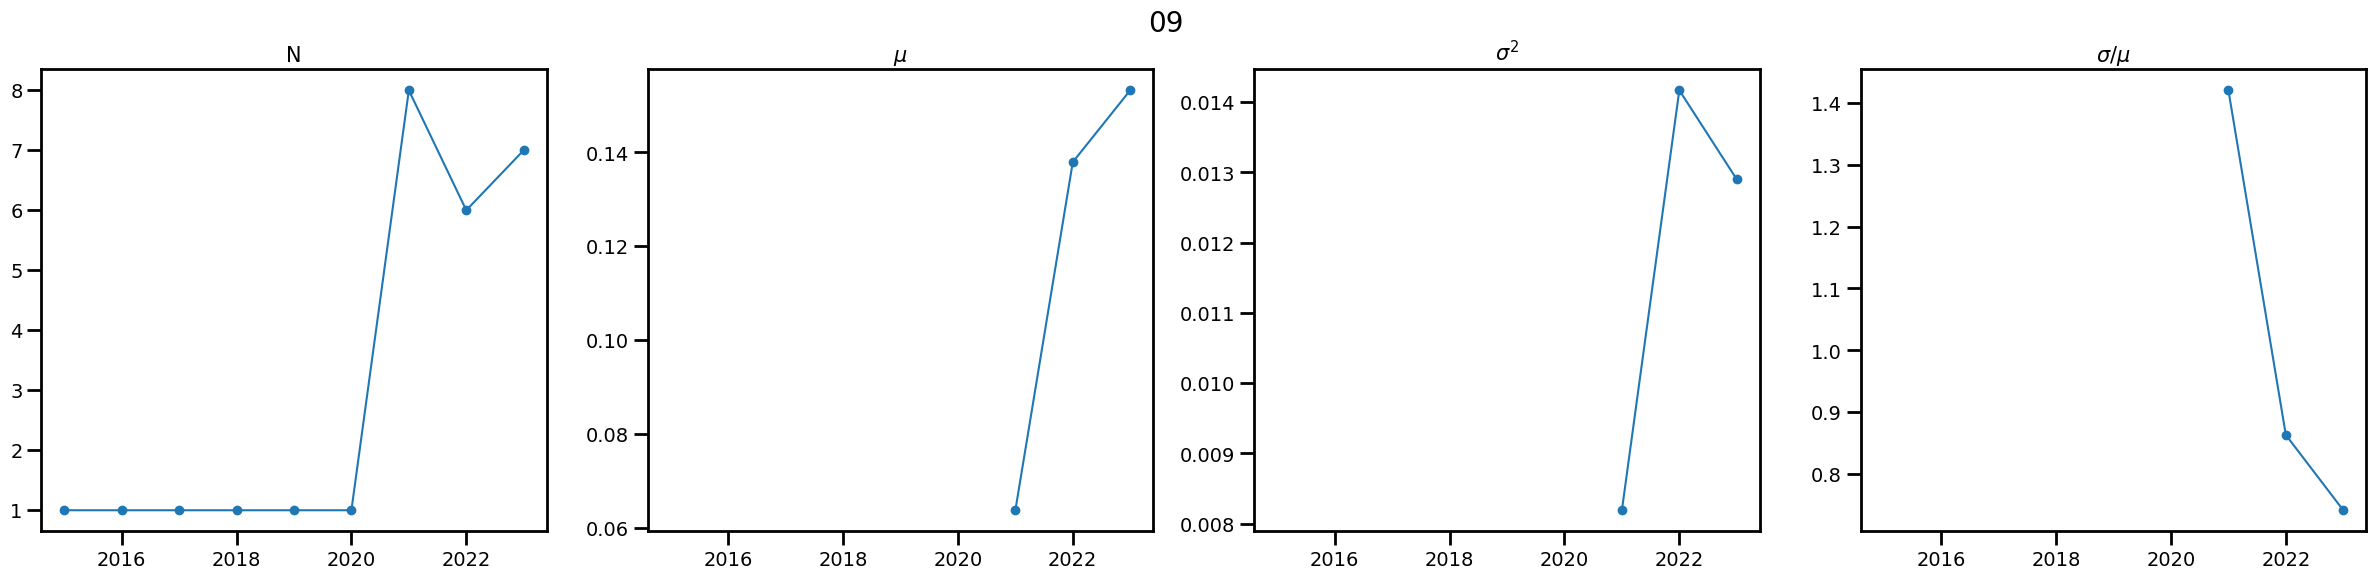

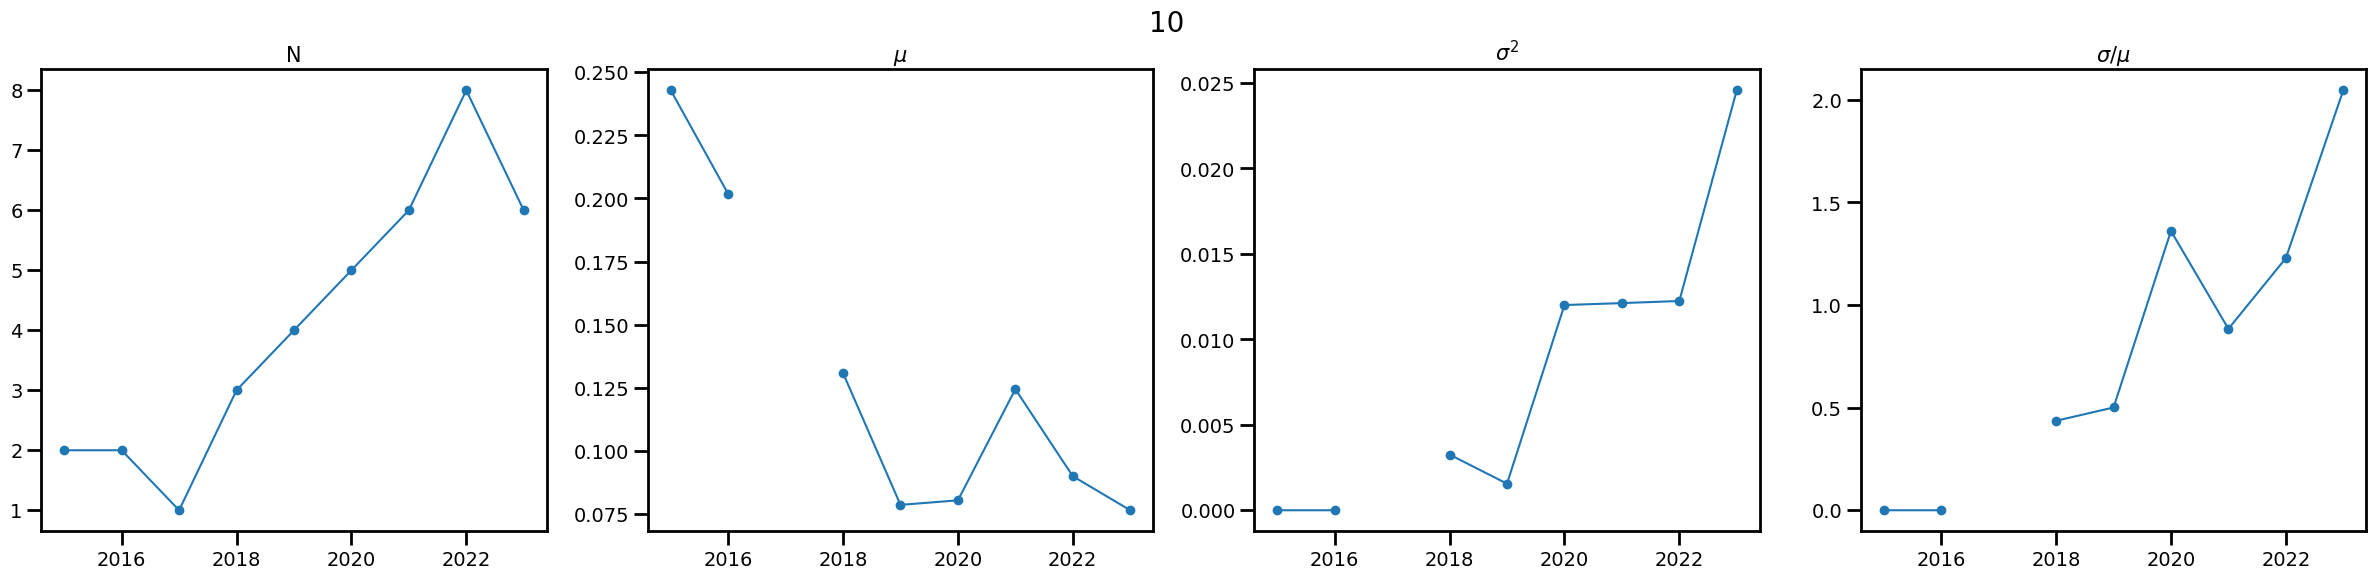

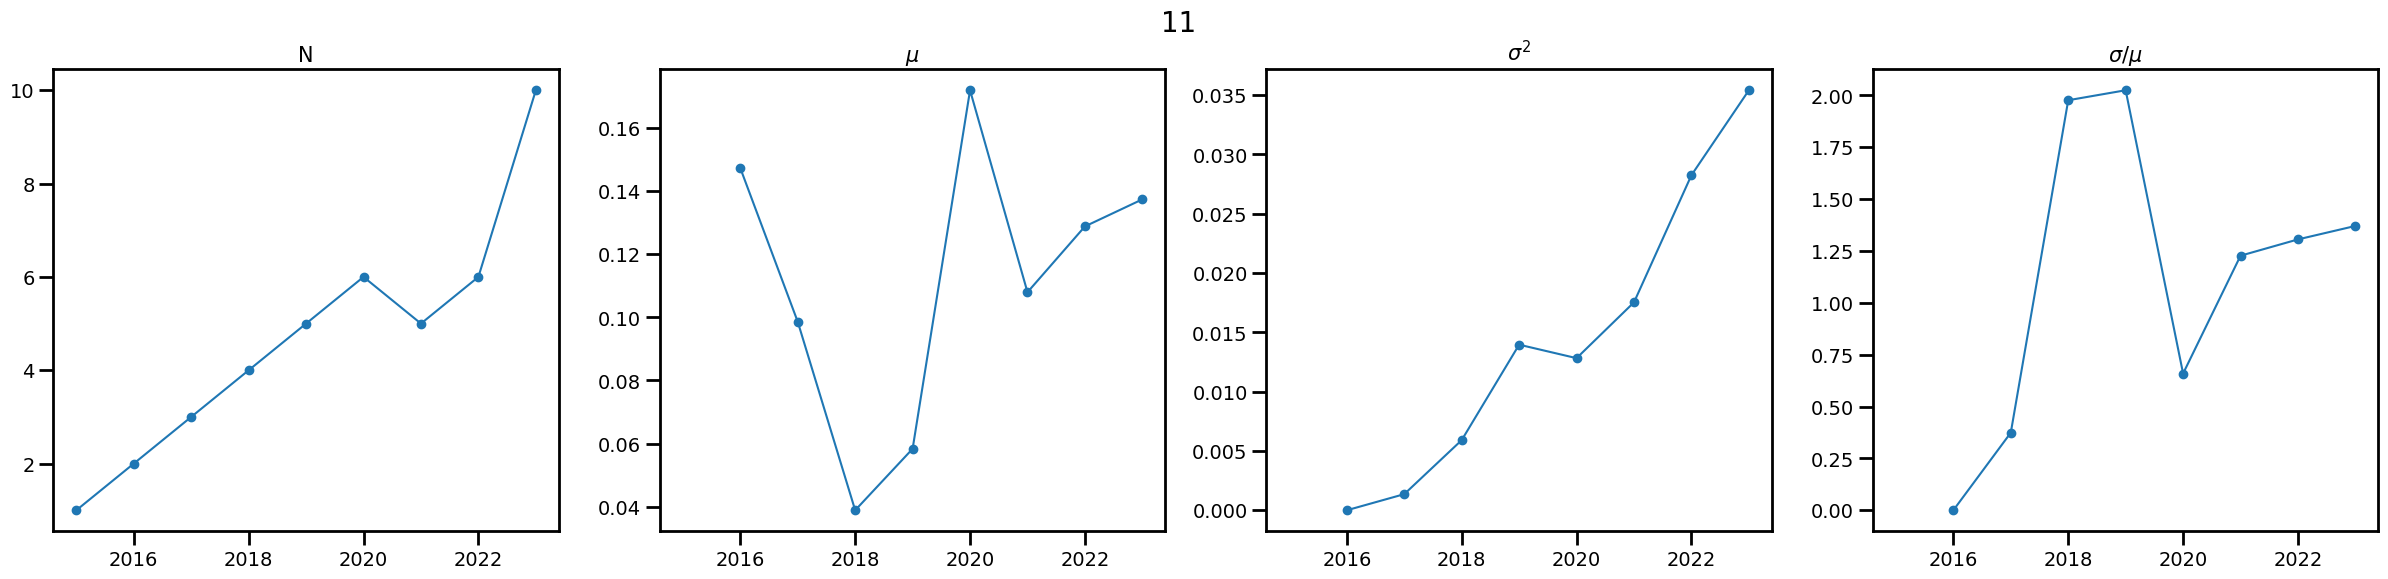

In [78]:
for sec in secs:
    fig, axs=plt.subplots(1, 4, sharex=True, figsize=(30, 6))
    plt.suptitle(sec, fontsize=20)
    axs[0].plot(list(int_sim_by_sec[sec].keys()), [couples2n(len(int_sim_by_sec[sec][year])) for year in years], marker='o')
    axs[0].set_title(r'N', fontsize=15)
    axs[1].plot(list(int_sim_by_sec[sec].keys()), [np.mean(int_sim_by_sec[sec][year]) for year in years], marker='o')
    axs[1].set_title(r'$\mu$', fontsize=15)
    axs[2].plot(list(int_sim_by_sec[sec].keys()), [np.var(int_sim_by_sec[sec][year]) for year in years], marker='o')
    axs[2].set_title(r'$\sigma^2$', fontsize=15)
    axs[3].plot(list(int_sim_by_sec[sec].keys()), [np.std(int_sim_by_sec[sec][year])/np.abs(np.mean(int_sim_by_sec[sec][year])) for year in years], marker='o')
    axs[3].set_title(r'$\sigma/\mu$', fontsize=15)
    plt.show()

Some sectors are two small to carry any information, let's consider only the greatest ones. 

In [79]:
reliable_th=5

In [80]:
reliable_secs=[]
for sec in secs:
    if all([couples2n(len(int_sim_by_sec[sec][year]))>=reliable_th for year in years]):
        reliable_secs.append(sec)

In [81]:
[(rs, sec_helper[rs]) for rs in reliable_secs]

[('01', 'Basic Materials'),
 ('02', 'Consumer Discretionary'),
 ('03', 'Consumer Staples')]

## MK by sector

In [82]:
for sec in reliable_secs:
    _mk=mk.original_test([np.mean(int_sim_by_sec[sec][year]) for year in years])
    if not _mk.h:
        print(f'{sec:}) {sec_helper[sec]:22}: {_mk.trend:}')
    else:
        print(f'{sec:}) {sec_helper[sec]:22}: {_mk.trend:}, p-value={_mk.p:.2e}, slope={_mk.slope:.2e}')

01) Basic Materials       : no trend
02) Consumer Discretionary: increasing, p-value=4.76e-02, slope=2.55e-03
03) Consumer Staples      : no trend


## Going back

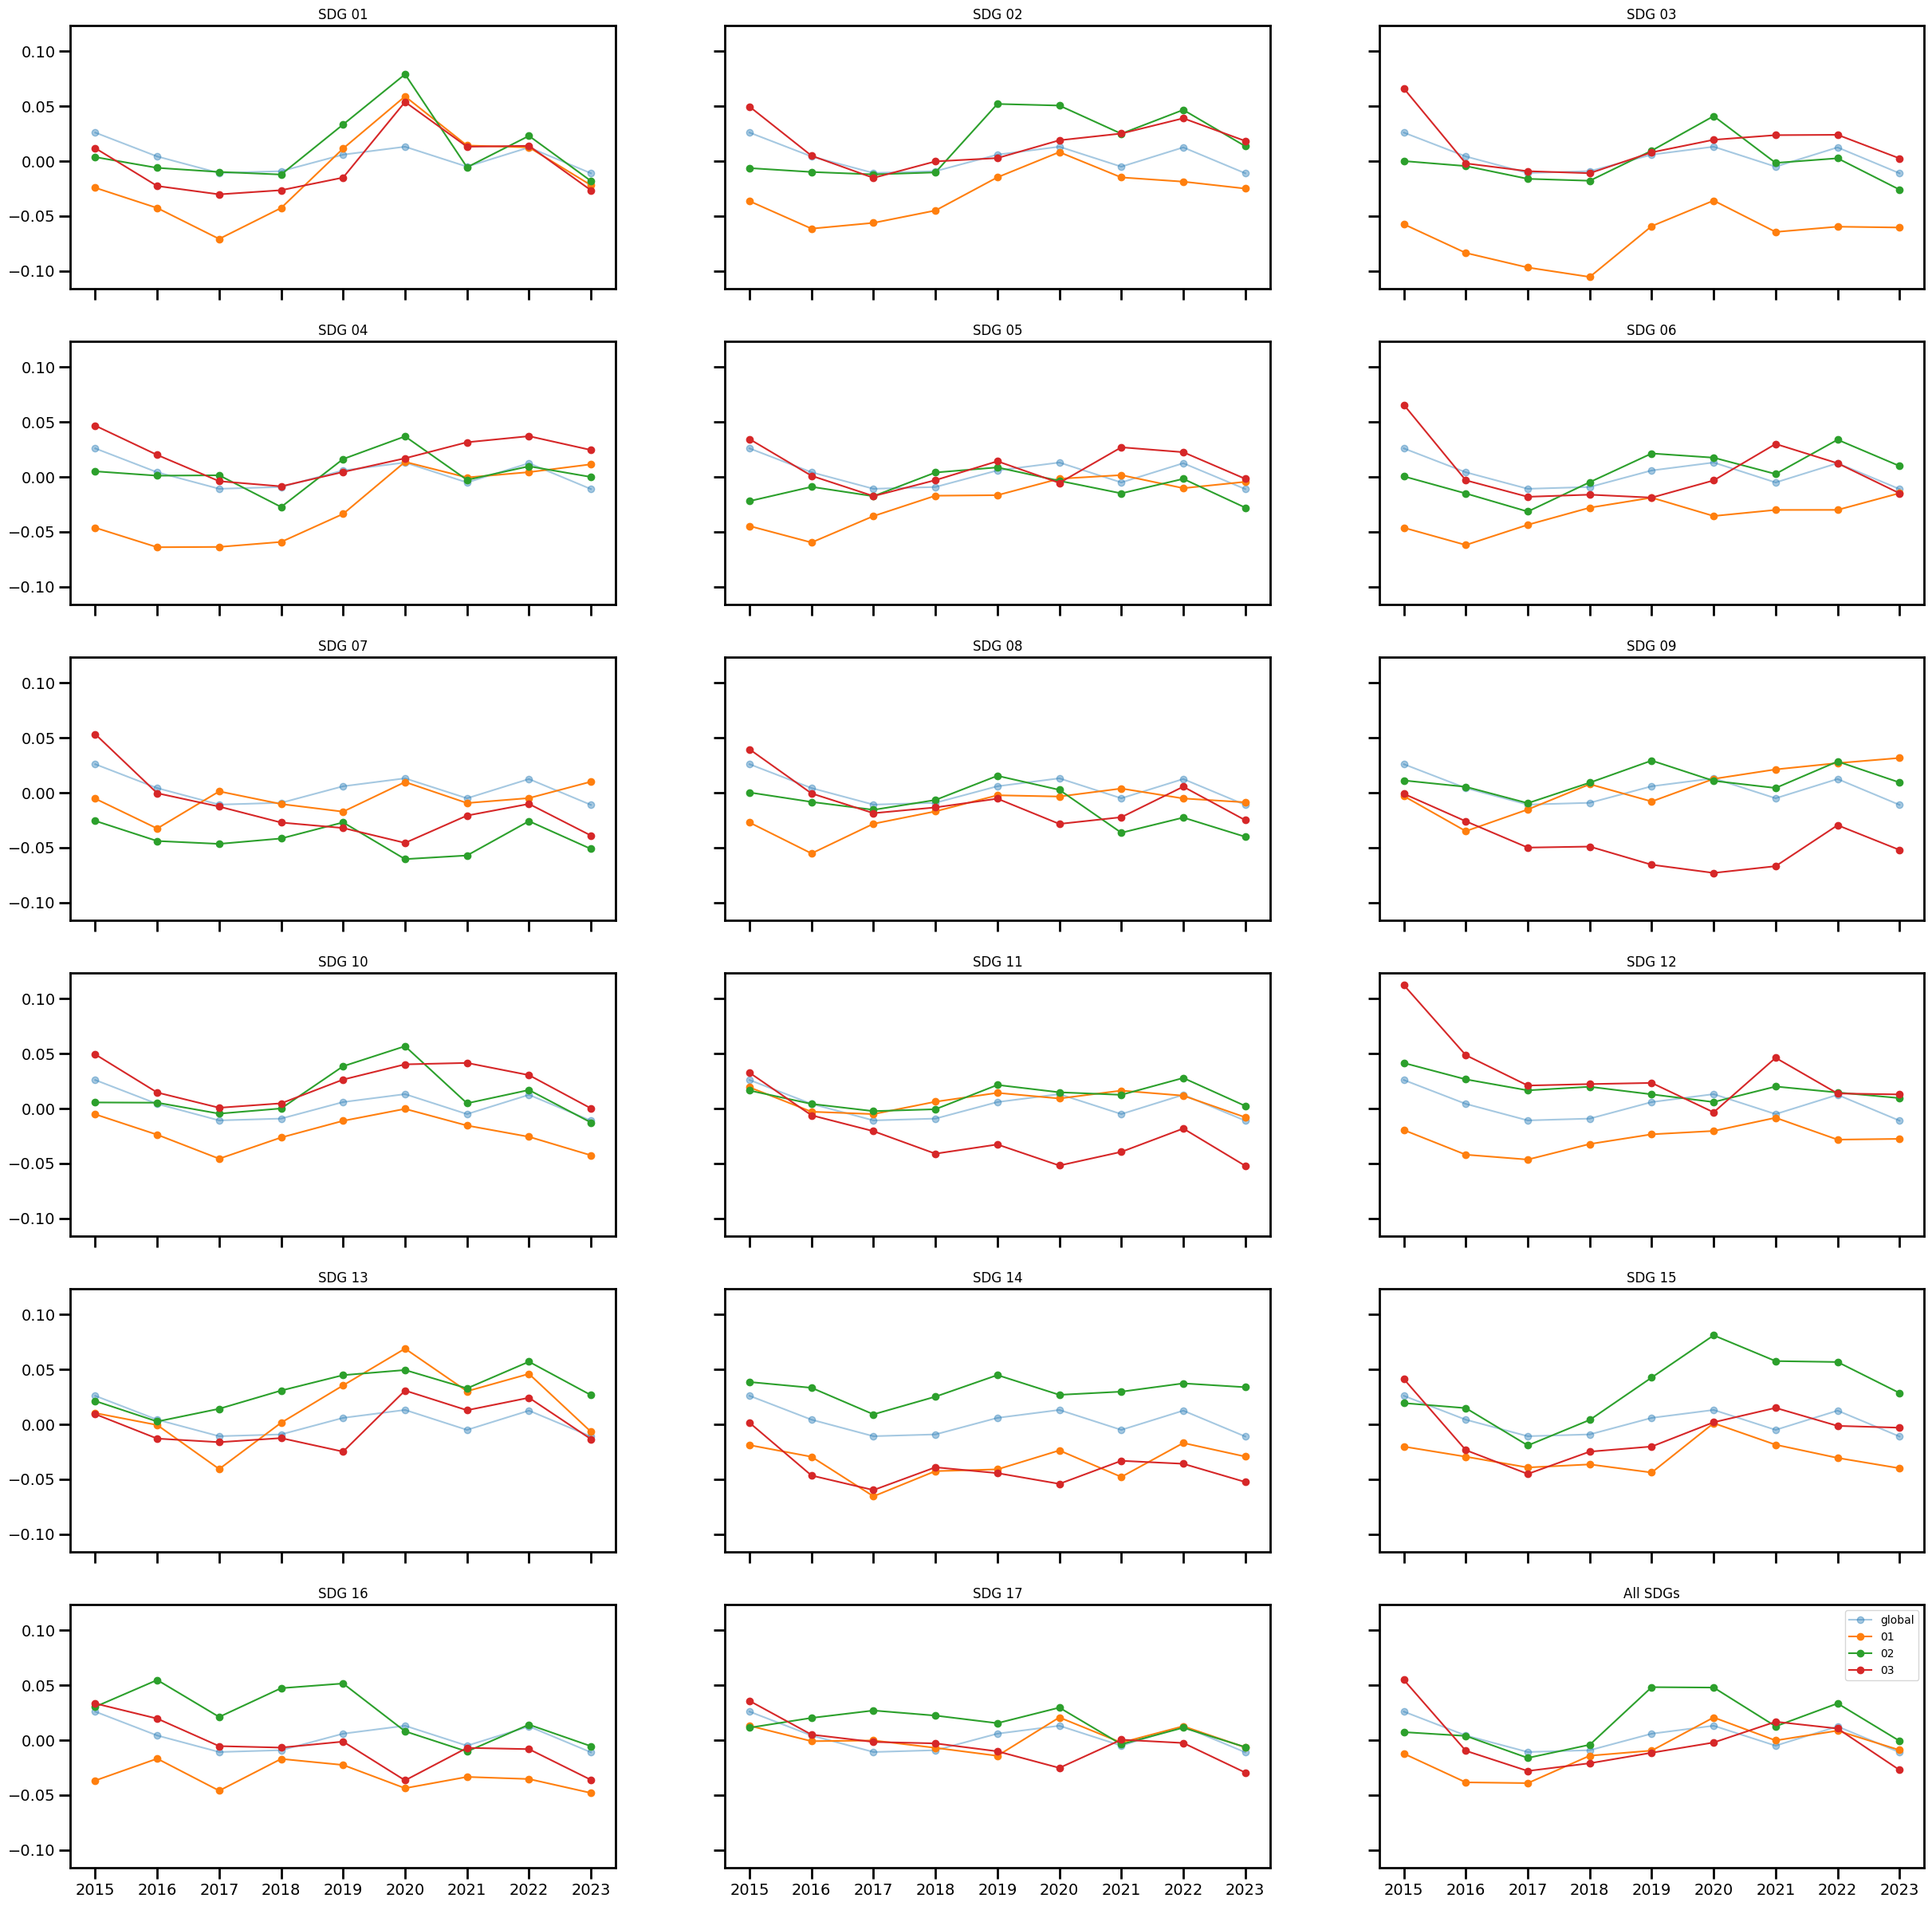

In [83]:
fig, axs=plt.subplots(6, 3, sharex=True, sharey=True, figsize=(30, 30))
for i_sdg, sdg in enumerate(sdgs):
    x_i=i_sdg//3
    y_i=i_sdg % 3
    axs[x_i, y_i].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global', alpha=0.4)
    for sec in reliable_secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        axs[x_i, y_i].plot(_selection['year'], _selection['mean'], marker='o', label=sec)
    #axs[x_i, y_i].legend()
    axs[x_i, y_i].set_title('SDG '+sdg)
axs[5,2].plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='global', alpha=0.4)
for sec in reliable_secs:
    axs[5,2].plot(cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['year'], cos_sims_by_sec[cos_sims_by_sec['sector']==sec]['mean'], marker='o', label=sec)
    axs[5,2].set_title('All SDGs')
axs[5,2].legend()

plt.show()

In [84]:
for sdg in sdgs:
    print(f'\nSDG{sdg:}\t{sdg_helper[sdg]:}\n---------------')
    for sec in reliable_secs:
        _selection=cos_sims_by_sec_by_SDG[np.logical_and(cos_sims_by_sec_by_SDG['sector']==sec, cos_sims_by_sec_by_SDG['SDG']==sdg)]
        cacca=mk.original_test(_selection['mean'])
        print(f'{sec:}) {sec_helper[sec]:22}: \033[1m{cacca.trend:10}\033[0m, p-value={cacca.p:.2e}, slope={cacca.slope:.2e}')


SDG01	No Poverty
---------------
01) Basic Materials       : no trend  , p-value=1.75e-01, slope=5.84e-03
02) Consumer Discretionary: no trend  , p-value=9.17e-01, slope=-1.28e-03
03) Consumer Staples      : no trend  , p-value=6.02e-01, slope=7.21e-04

SDG02	Zero hunger
---------------
01) Basic Materials       : no trend  , p-value=2.51e-01, slope=5.24e-03
02) Consumer Discretionary: no trend  , p-value=4.66e-01, slope=4.53e-03
03) Consumer Staples      : no trend  , p-value=4.66e-01, slope=3.81e-03

SDG03	Good health and well-being
---------------
01) Basic Materials       : no trend  , p-value=9.17e-01, slope=2.66e-03
02) Consumer Discretionary: no trend  , p-value=9.17e-01, slope=-9.49e-04
03) Consumer Staples      : no trend  , p-value=6.02e-01, slope=2.10e-03

SDG04	Quality education
---------------
01) Basic Materials       : increasing, p-value=1.65e-02, slope=1.11e-02
02) Consumer Discretionary: no trend  , p-value=1.00e+00, slope=9.84e-05
03) Consumer Staples      : no tren

# Aggregated SDGs

In [123]:
social_sdgs=['01','02','03','04','05','10','16','17']
economic_sdgs=['07','08','09','11','12']
environmental_sdgs=['06','13','14','15']

## Mean vectors

In [124]:
[goalvecfile for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in social_sdgs])]

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt']

In [125]:
social_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in social_sdgs])]
social_vec=np.mean(social_vec, axis=0)

In [126]:
economic_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in economic_sdgs])]
economic_vec=np.mean(economic_vec, axis=0)

In [127]:
environmental_vec=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles if any([sdg in goalvecfile for sdg in environmental_sdgs])]
environmental_vec=np.mean(environmental_vec, axis=0)

In [128]:
clustered_sdgs=np.array([social_vec, economic_vec, environmental_vec])

In [129]:
clustered_sdgs.shape

(3, 768)

## Global

In [130]:
cos_sims_global_cluster=np.zeros((3, len(years)), dtype=[('mean', 'f8'), ('all', object)])

In [131]:
for i_y, year in enumerate(tqdm(years)):
    for i_c, cluster in enumerate(['Social', 'Economic', 'Environmental']):
    
        cos_sims_global_cluster[i_c, i_y]['all']=np.array([float(util.cos_sim(clustered_sdgs[i_c], vec)) for vec in vectors[vectors['year']==year]['vector']])
        cos_sims_global_cluster[i_c, i_y]['mean']=np.mean(cos_sims_global_cluster[i_c, i_y]['all'])
        

  0%|          | 0/9 [00:00<?, ?it/s]

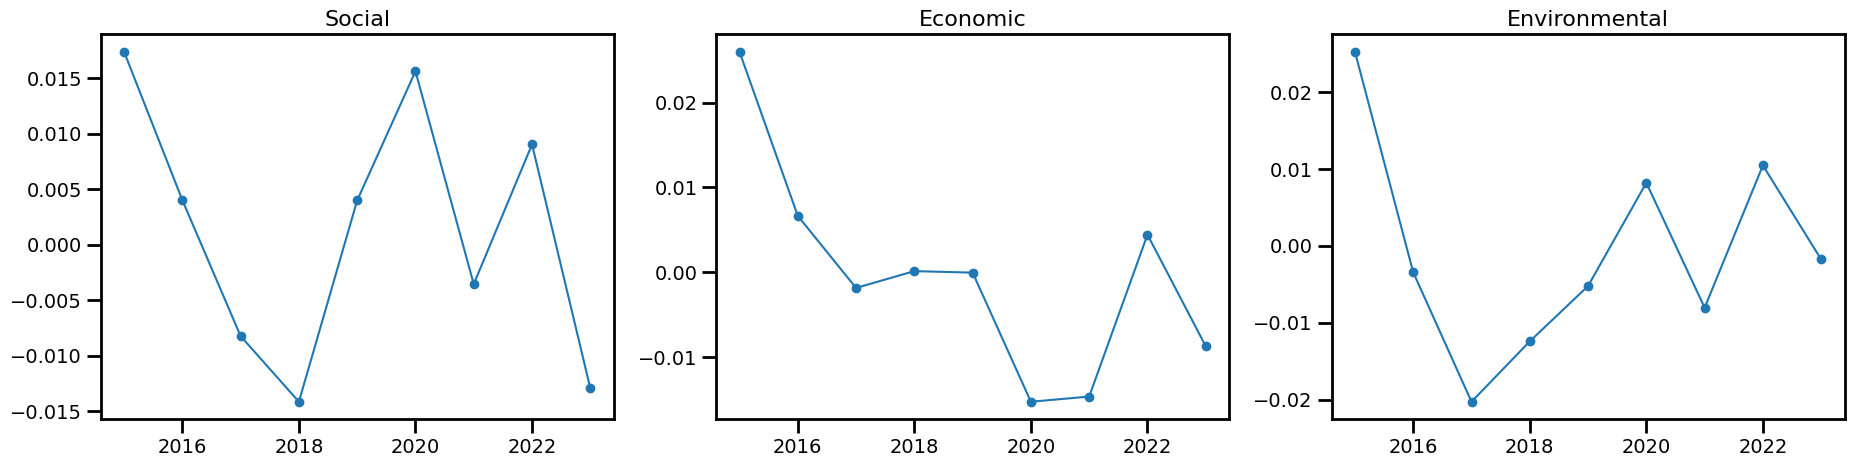

In [145]:
fig, axs=plt.subplots(1, 3, sharex=True, figsize=(22.5, 5))
for i_ax, ax in enumerate(axs):
    ax.plot(np.arange(2015, 2024), cos_sims_global_cluster[i_ax]['mean'], marker='o')
    ax.set_title(sdg_sectors[i_ax], fontsize=16)
plt.show()

In [165]:
sdg_sectors=['Social', 'Economic', 'Environmental']
sdg_sec_color=['lime', 'darkturquoise','mediumvioletred']

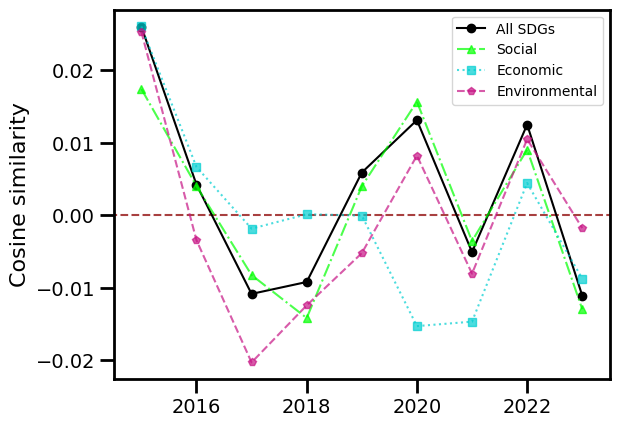

In [177]:
plt.hlines(0., 2010, 2030, ls='--', color='darkred', alpha=0.75)
plt.plot(np.arange(2015, 2024), cos_sims_global['mean'], marker='o', label='All SDGs', color='black')
for i_sdg,sdg in enumerate(sdg_sectors):
    plt.plot(np.arange(2015, 2024), cos_sims_global_cluster[i_sdg]['mean'], label=sdg, alpha=0.7, color=sdg_sec_color[i_sdg], ls=_lss[len(_lss)-1-i_sdg % len(_lss)], marker=_markers[i_sdg %len(_markers)])
plt.xlim(2014.5, 2023.5)
plt.ylabel('Cosine similarity', fontsize=16)
plt.legend()
plt.savefig('./NewPlots/trends_all_secs_vs_aggr_sdgs.png', bbox_inches='tight', dpi=300)
plt.show()

### MK

In [178]:
for i_c, cluster in enumerate(['Social', 'Economic', 'Environmental']):
    _aux=mk.original_test(cos_sims_global_cluster[i_c,:]['mean'])
    print(f'{cluster:14}) {_aux.trend:}, p-value={_aux.p:.2e}, slope={_aux.slope:.2e}')

Social        ) no trend, p-value=4.66e-01, slope=-1.35e-03
Economic      ) no trend, p-value=1.18e-01, slope=-3.14e-03
Environmental ) no trend, p-value=7.54e-01, slope=9.96e-04


## By sector

In [146]:
cos_sims_sec_cluster=np.zeros((3*len(secs), len(years)), dtype=[('mean', 'f8'), ('all', object)])

In [147]:
for i_y, year in enumerate(tqdm(years)):
    for i_c, cluster in enumerate(sdg_sectors):
        for i_s, sec in enumerate(secs):
            cos_sims_sec_cluster[i_c*len(secs)+i_s, i_y]['all']=np.array([float(util.cos_sim(clustered_sdgs[i_c], vec)) for vec in vectors[np.logical_and(vectors['year']==year, vectors['sector']==sec)]['vector']])
            cos_sims_sec_cluster[i_c*len(secs)+i_s, i_y]['mean']=np.mean(cos_sims_sec_cluster[i_c*len(secs)+i_s, i_y]['all'])        

  0%|          | 0/9 [00:00<?, ?it/s]

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


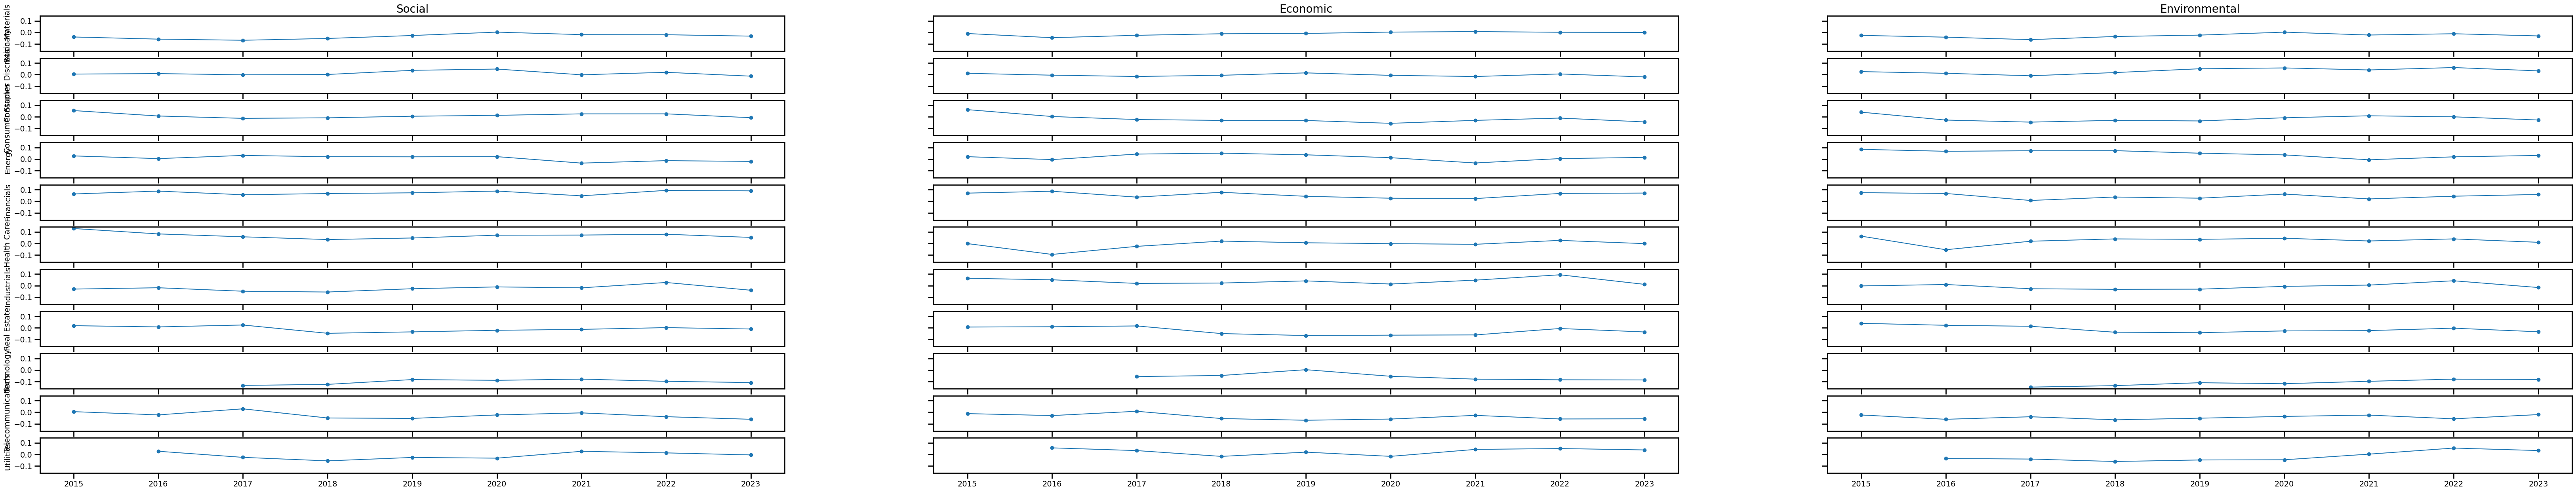

In [151]:
fig, axs=plt.subplots(len(secs), 3, sharex=True, figsize=(11*7.5, 15), sharey=True)
for i_s, sec in enumerate(secs):
    for i_c, cluster in enumerate(sdg_sectors):
        _mean=cos_sims_sec_cluster[i_c*len(secs)+i_s]['mean']
        axs[i_s,i_c].plot(np.arange(2015, 2024), _mean, marker='o')
        if i_s==0:
            axs[i_s,i_c].set_title(sdg_sectors[i_c], fontsize=20)
        if i_c==0:
            axs[i_s,i_c].set_ylabel(sec_helper[sec], fontsize=14)
plt.show()

In [152]:
_p_vals={}
for i_c, cluster in enumerate(sdg_sectors):
    print(f'\n\033[1m{cluster:}\033[0m')
    _p_vals[cluster]=[]
    for i_s, sec in enumerate(secs):
        _aux=mk.original_test(cos_sims_sec_cluster[i_c*len(secs)+i_s]['mean'])
        if _aux.trend!='no trend': 
            print(f'\033[3m{sec_helper[sec]:22}\033[0m \033[1m{_aux.trend:}\033[0m, p-value={_aux.p:.2e}, slope={_aux.slope:.2e}')
        else:
            print(f'{sec_helper[sec]:22} {_aux.trend:}, p-value={_aux.p:.2e}, slope={_aux.slope:.2e}')
        _p_vals[cluster].append(_aux.p)


Social
Basic Materials        no trend, p-value=1.75e-01, slope=3.76e-03
Consumer Discretionary no trend, p-value=9.17e-01, slope=-9.79e-04
Consumer Staples       no trend, p-value=7.54e-01, slope=5.90e-04
Energy                 no trend, p-value=7.63e-02, slope=-5.99e-03
Financials             no trend, p-value=1.75e-01, slope=3.16e-03
Health Care            no trend, p-value=6.02e-01, slope=-2.38e-03
Industrials            no trend, p-value=4.66e-01, slope=2.44e-03
Real Estate            no trend, p-value=7.54e-01, slope=-2.50e-03
Technology             no trend, p-value=5.48e-01, slope=4.11e-03
Telecommunications     no trend, p-value=1.18e-01, slope=-5.97e-03
Utilities              no trend, p-value=1.00e+00, slope=1.71e-03

Economic
Basic Materials        increasing, p-value=4.76e-02, slope=3.72e-03
Consumer Discretionary no trend, p-value=1.75e-01, slope=-1.99e-03
Consumer Staples       no trend, p-value=7.63e-02, slope=-6.65e-03
Energy                 no trend, p-value=4.66e-01

### Mean old FDR

In [164]:
for cluster in sdg_sectors:
    print(cluster, fdr_th(_p_vals[cluster], 0.05))

Social 0.0
Economic 0.0
Environmental 0.0


### Plots

In [153]:
trend_color={'increasing':'green', 'no trend':'orange', 'decreasing':'red'}

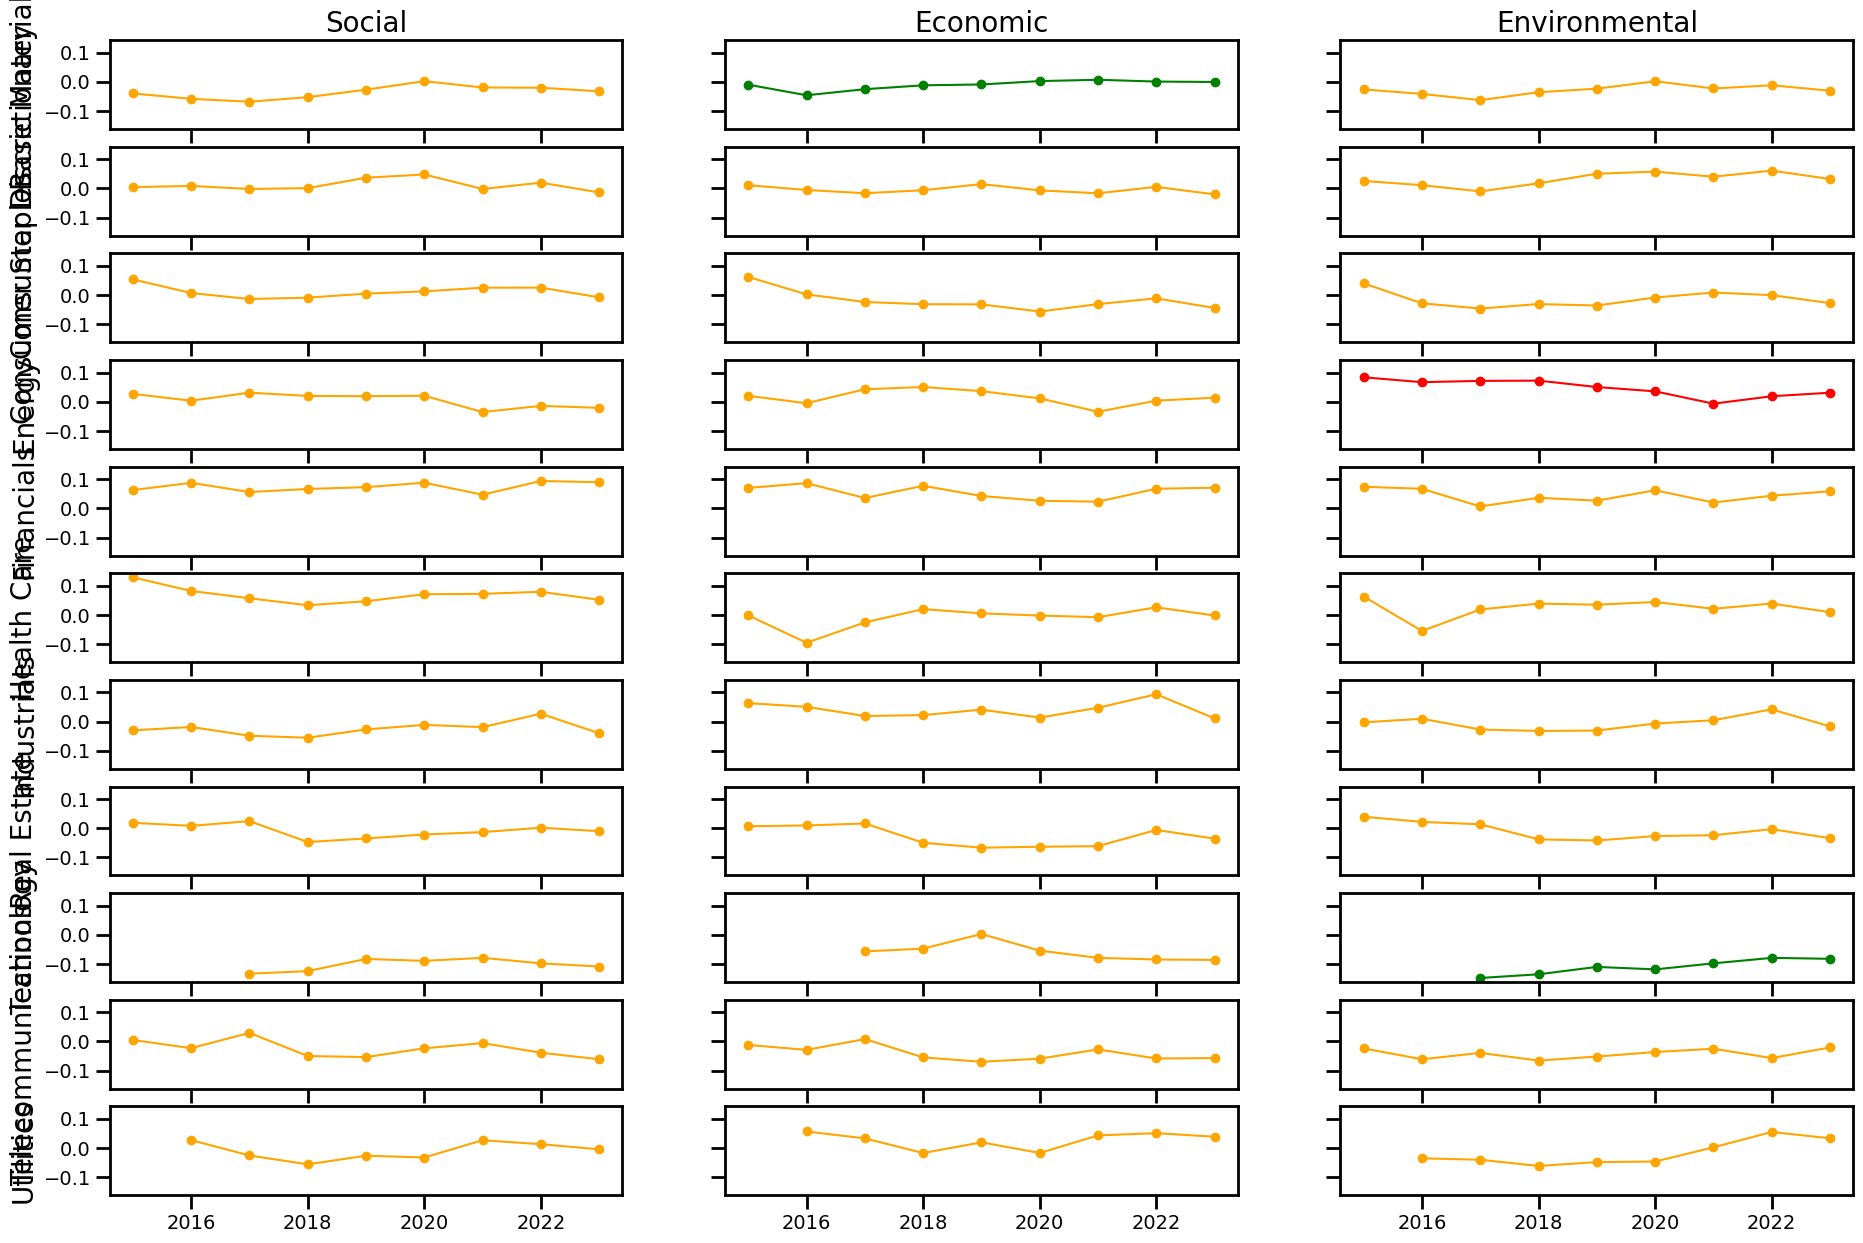

In [157]:
fig, axs=plt.subplots(len(secs), 3, sharex=True, figsize=(22.5, 15), sharey=True)
for i_s, sec in enumerate(secs):
    for i_c, cluster in enumerate(sdg_sectors):
        _mean=cos_sims_sec_cluster[i_c*len(secs)+i_s]['mean']
        _aux=mk.original_test(_mean)
        axs[i_s,i_c].plot(np.arange(2015, 2024), _mean, marker='o', c=trend_color[_aux.trend])
        if i_s==0:
            axs[i_s,i_c].set_title(sdg_sectors[i_c], fontsize=20)
        if i_c==0:
            axs[i_s,i_c].set_ylabel(sec_helper[sec], fontsize=20)
plt.show()

In [159]:
markers=['o', 'x', '+']
ls=['-', '--', '-.']

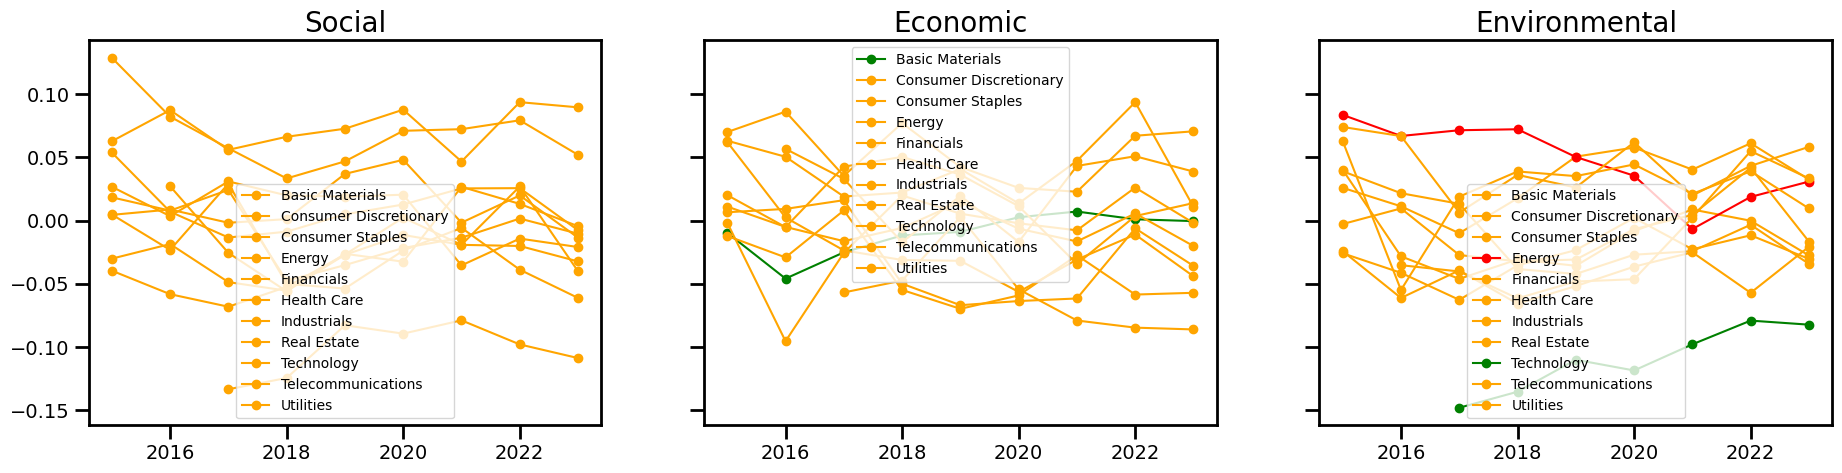

In [163]:
fig, axs=plt.subplots(1, 3, sharex=True, figsize=(22.5, 5), sharey=True)
for i_c, cluster in enumerate(sdg_sectors):
    for i_s, sec in enumerate(secs):
        _mean=cos_sims_sec_cluster[i_c*len(secs)+i_s]['mean']
        _aux=mk.original_test(_mean)
        axs[i_c].plot(np.arange(2015, 2024), _mean, c=trend_color[_aux.trend], label=sec_helper[sec], marker='o')
        
    axs[i_c].set_title(sdg_sectors[i_c], fontsize=20)
    axs[i_c].legend()
plt.show()